In [22]:
import numpy as np
import pandas as pd
from functools import reduce
import importlib
import datetime as dt
from datetime import datetime
from pandas import concat
from math import sqrt
from sklearn import metrics
from sklearn import preprocessing as prep
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_pinball_loss as pinball
from matplotlib.pyplot import figure
from epftoolbox.evaluation import sMAPE
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import rankdata
from sklearn.metrics import log_loss
from scipy.stats import chi2
from scipy.stats import rankdata
import warnings
import vartests
from vartests import kupiec_test

warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)
def pinball(y_true, quantile_forecast, alpha):
    pinball_loss = np.maximum((y_true - quantile_forecast) * alpha, (quantile_forecast - y_true) * (1 - alpha))
    return np.mean(pinball_loss)
def winkler_score(y_true, lower_bound, upper_bound, alpha):
    if alpha == 0.3 or alpha == 0.7:
        alpha = 0.4
    elif alpha == 0.1 or alpha == 0.9:
        alpha = 0.8   
    y_true = np.array(y_true)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)
    B_t_h = upper_bound - lower_bound
    within_interval = (y_true >= lower_bound) & (y_true <= upper_bound)    
    score = np.zeros_like(y_true, dtype=float)    
    if alpha == 0.5:
        score += np.where(within_interval, 0.5 * B_t_h, 0)  # Condition 1 (special case for alpha=0.5)
    else:
        score += np.where(within_interval, B_t_h, 0)  # Condition 1
    score += np.where(y_true < lower_bound, (2 / alpha) * (lower_bound - y_true), 0)  # Condition 2
    score += np.where(y_true > upper_bound, (2 / alpha) * (y_true - upper_bound), 0)  # Condition 3
    winkler_score = np.mean(score)
    return winkler_score
def calculate_picp(y_true, lower_bound, upper_bound, alpha):
    if alpha == 0.5:
        within_interval = np.greater_equal(y_true, lower_bound)
    else:
        within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)    
    picp = np.mean(within_interval)
    return picp
def calculate_uc_cc(y_true, lower_bound, upper_bound):
    within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)
    uc = np.mean(within_interval)    
    independence = np.mean(np.logical_and(lower_bound <= y_true.shift(1), y_true.shift(1) <= upper_bound))
    cc = uc - independence    
    return uc
def assess_prediction_intervals(y_true, lower_bound, upper_bound, alpha=0.05):
    within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)
    empirical_coverage = np.mean(within_interval)
    sharpness = np.mean(upper_bound - lower_bound)
    return empirical_coverage
def calculate_additional_metrics(y_true, lower_bound, upper_bound, alpha):
    reliability = assess_prediction_intervals(y_true, lower_bound, upper_bound)
    winkler = winkler_score(y_true, lower_bound, upper_bound, alpha)
    width = np.abs(upper_bound - lower_bound).mean().values[0]
    picp = calculate_picp(y_true, lower_bound, upper_bound, alpha)
    uc = calculate_uc_cc(y_true, lower_bound, upper_bound)
    return  winkler, width, picp, uc

def calculate_violations(y_true, lower_quantile_forecast, upper_quantile_forecast):
    violations = (y_true < lower_quantile_forecast) | (y_true > upper_quantile_forecast)
    return violations.astype(int)  # Convert True/False to 1/0

def calculate_total_violations(y_true_list, lower_quantile_forecast_list, upper_quantile_forecast_list):
    all_violations = pd.DataFrame()

    for y_true, lower_quantile_forecast, upper_quantile_forecast in zip(y_true_list, lower_quantile_forecast_list, upper_quantile_forecast_list):
        violations = calculate_violations(y_true, lower_quantile_forecast, upper_quantile_forecast)
        all_violations = pd.concat([all_violations, violations], axis=1)

    total_violations = all_violations.sum(axis=1)
    return total_violations, all_violations

def perform_kupiec_test(all_violations, var_conf_level=0.99, conf_level=0.95):
    result = kupiec_test(all_violations, var_conf_level=var_conf_level, conf_level=conf_level)
    return result

Performance Metrics for Quantile RMSE:
RMSE: 42.26
RMSE: 35.49
RMSE: 30.92
RMSE: 26.66
RMSE: 29.78
RMSE: 33.02

Performance Metrics for Quantile MAE:
MAE: 29.79
MAE: 22.27
MAE: 17.77
MAE: 14.80
MAE: 17.26
MAE: 20.38

Performance Metrics for Quantile Pinball Score:
Pinball Score: 3.36
Pinball Score: 7.17
Pinball Score: 8.88
Pinball Score: 8.47
Pinball Score: 5.35
Pinball Score: 6.65

Performance Metrics for Quantile sMAPE:
sMAPE: 72.46
sMAPE: nan
sMAPE: 37.47
sMAPE: 31.25
sMAPE: 32.36
sMAPE: 43.39

Performance Metrics for Quantile Winkler Score:
Winkler Score: 38.49
Winkler Score: 61.51
Winkler Score: 71.08
Winkler Score: 128.77
Winkler Score: 105.11
Winkler Score: 57.02

Performance Metrics for Quantile Mean Width:
Mean Width: 37.04
Mean Width: 14.44
Mean Width: 0.00
Mean Width: 14.44
Mean Width: 37.04
Mean Width: 25.74

Performance Metrics for Quantile coverage:
coverage: 0.64
coverage: 0.29
coverage: 0.76
coverage: 0.00
coverage: 0.00
coverage: 0.56

Total hours that reject the null 

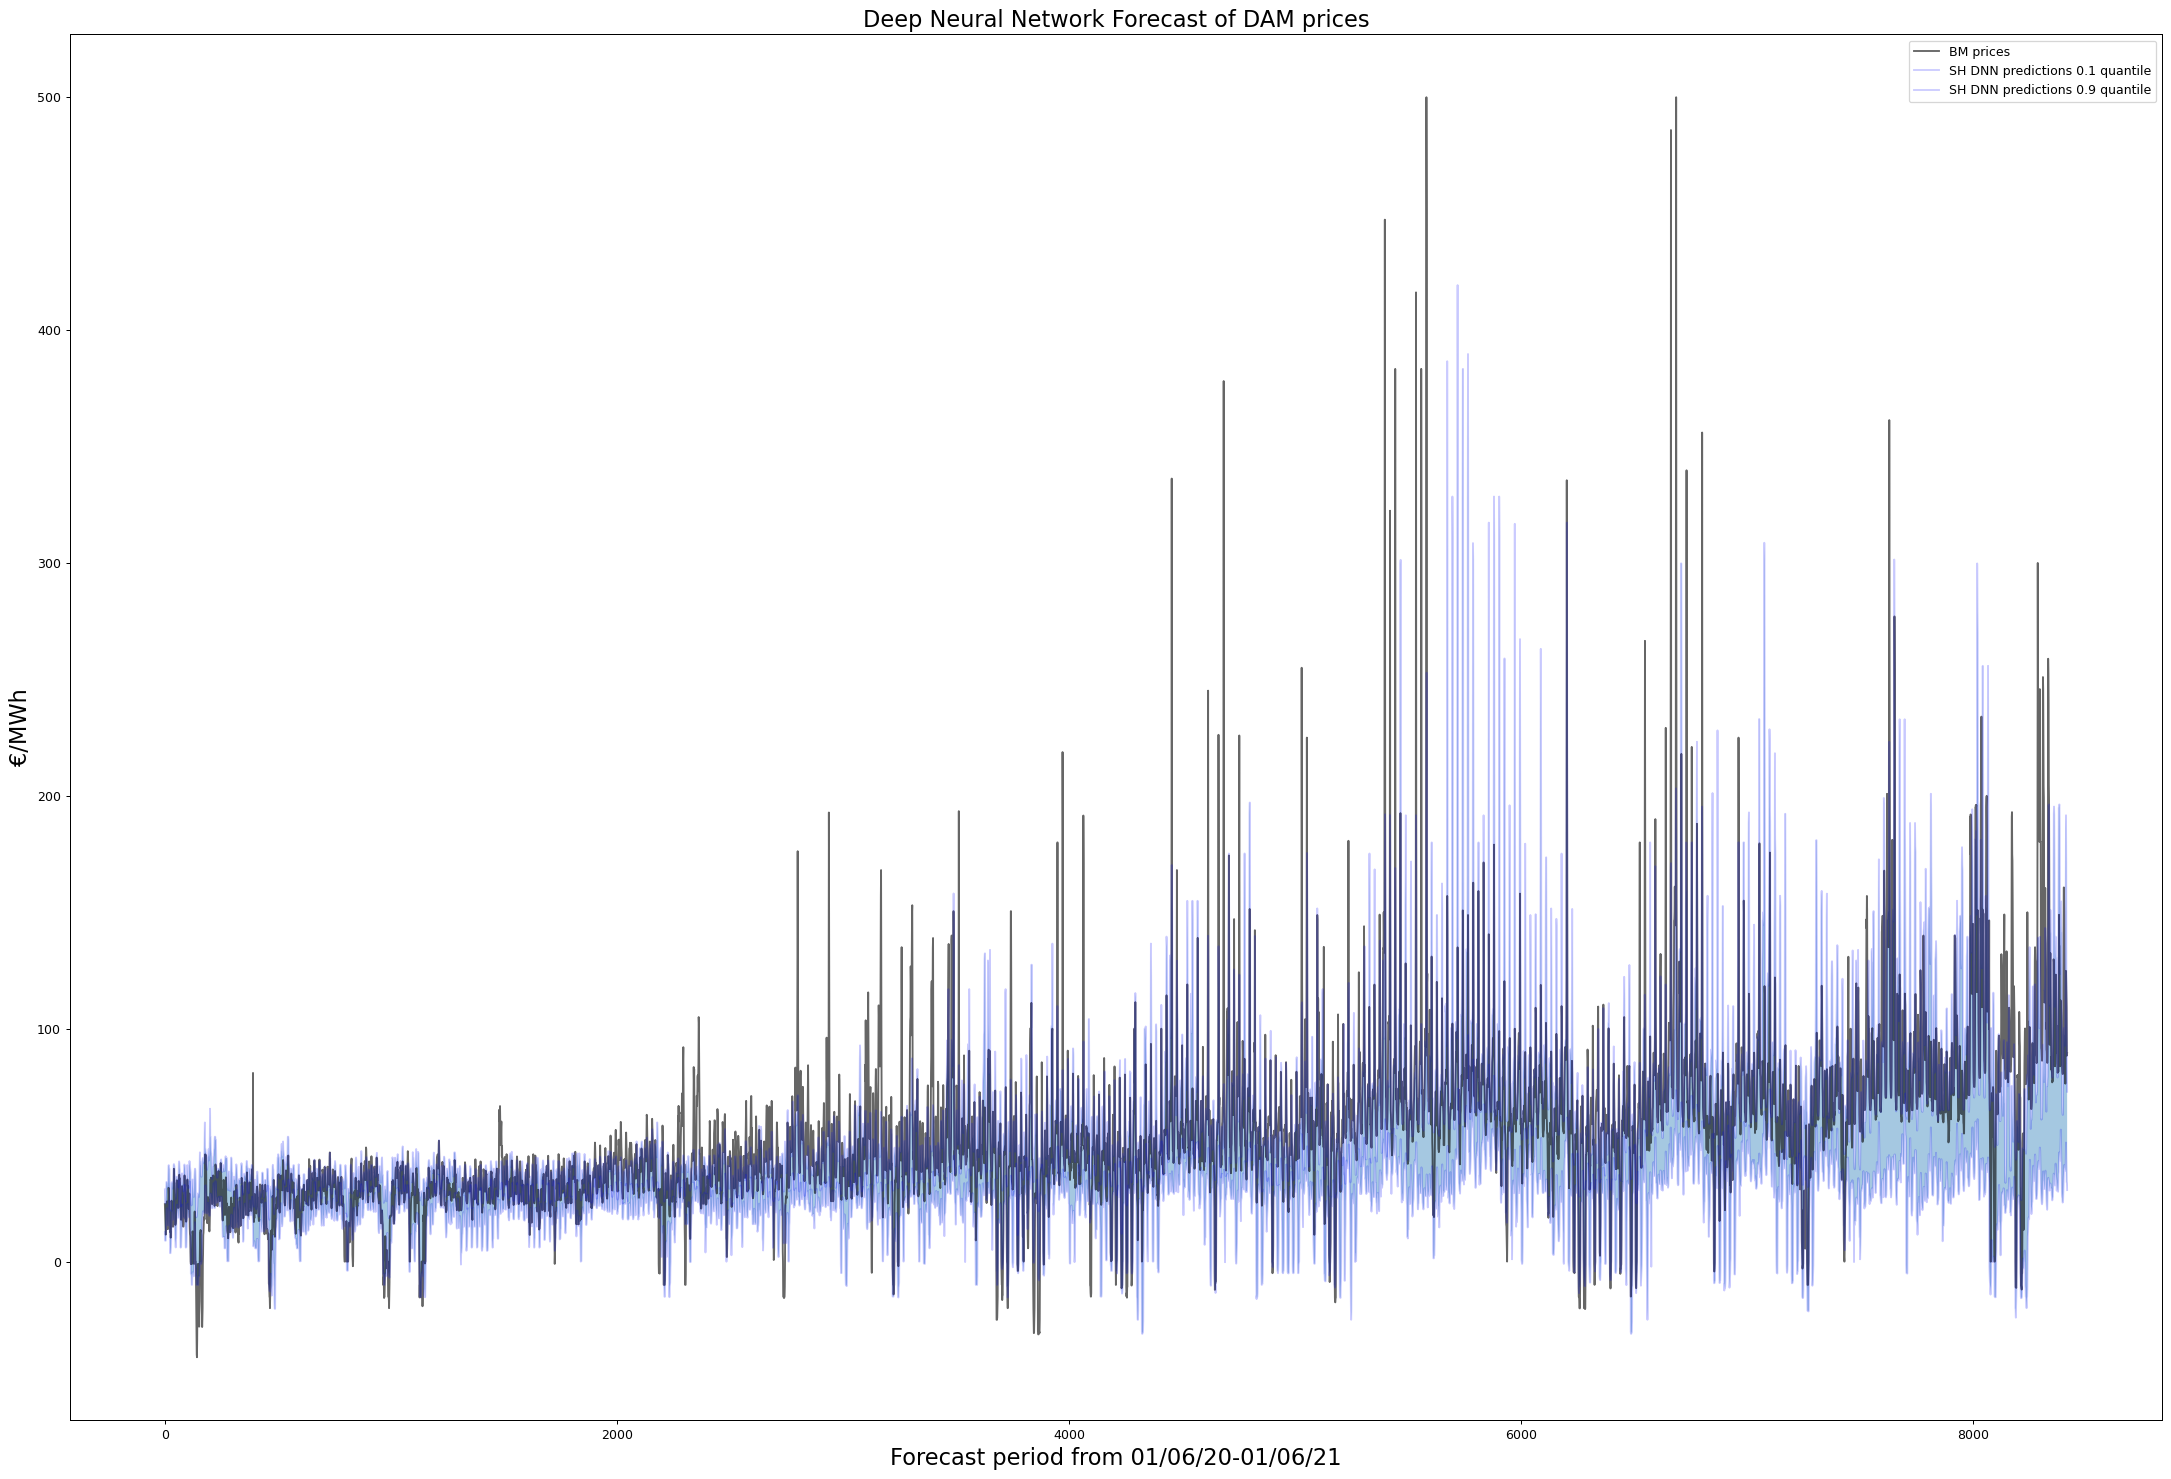

In [26]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/knn_Q_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)



metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 43.56
RMSE: 30.21
RMSE: 25.32
RMSE: 26.39
RMSE: 35.92
RMSE: 32.28

Performance Metrics for Quantile MAE:
MAE: 32.34
MAE: 18.97
MAE: 13.73
MAE: 16.87
MAE: 27.12
MAE: 21.81

Performance Metrics for Quantile Pinball Score:
Pinball Score: 3.84
Pinball Score: 6.48
Pinball Score: 6.87
Pinball Score: 6.67
Pinball Score: 4.70
Pinball Score: 5.71

Performance Metrics for Quantile sMAPE:
sMAPE: 102.42
sMAPE: 46.47
sMAPE: nan
sMAPE: 37.49
sMAPE: 50.08
sMAPE: 59.11

Performance Metrics for Quantile Winkler Score:
Winkler Score: 53.51
Winkler Score: 45.99
Winkler Score: 54.92
Winkler Score: 149.23
Winkler Score: 140.56
Winkler Score: 51.47

Performance Metrics for Quantile Mean Width:
Mean Width: 52.99
Mean Width: 23.84
Mean Width: 0.00
Mean Width: 23.84
Mean Width: 52.99
Mean Width: 38.42

Performance Metrics for Quantile coverage:
coverage: 0.85
coverage: 0.66
coverage: 0.66
coverage: 0.00
coverage: 0.00
coverage: 0.73

Total hours that reject the null

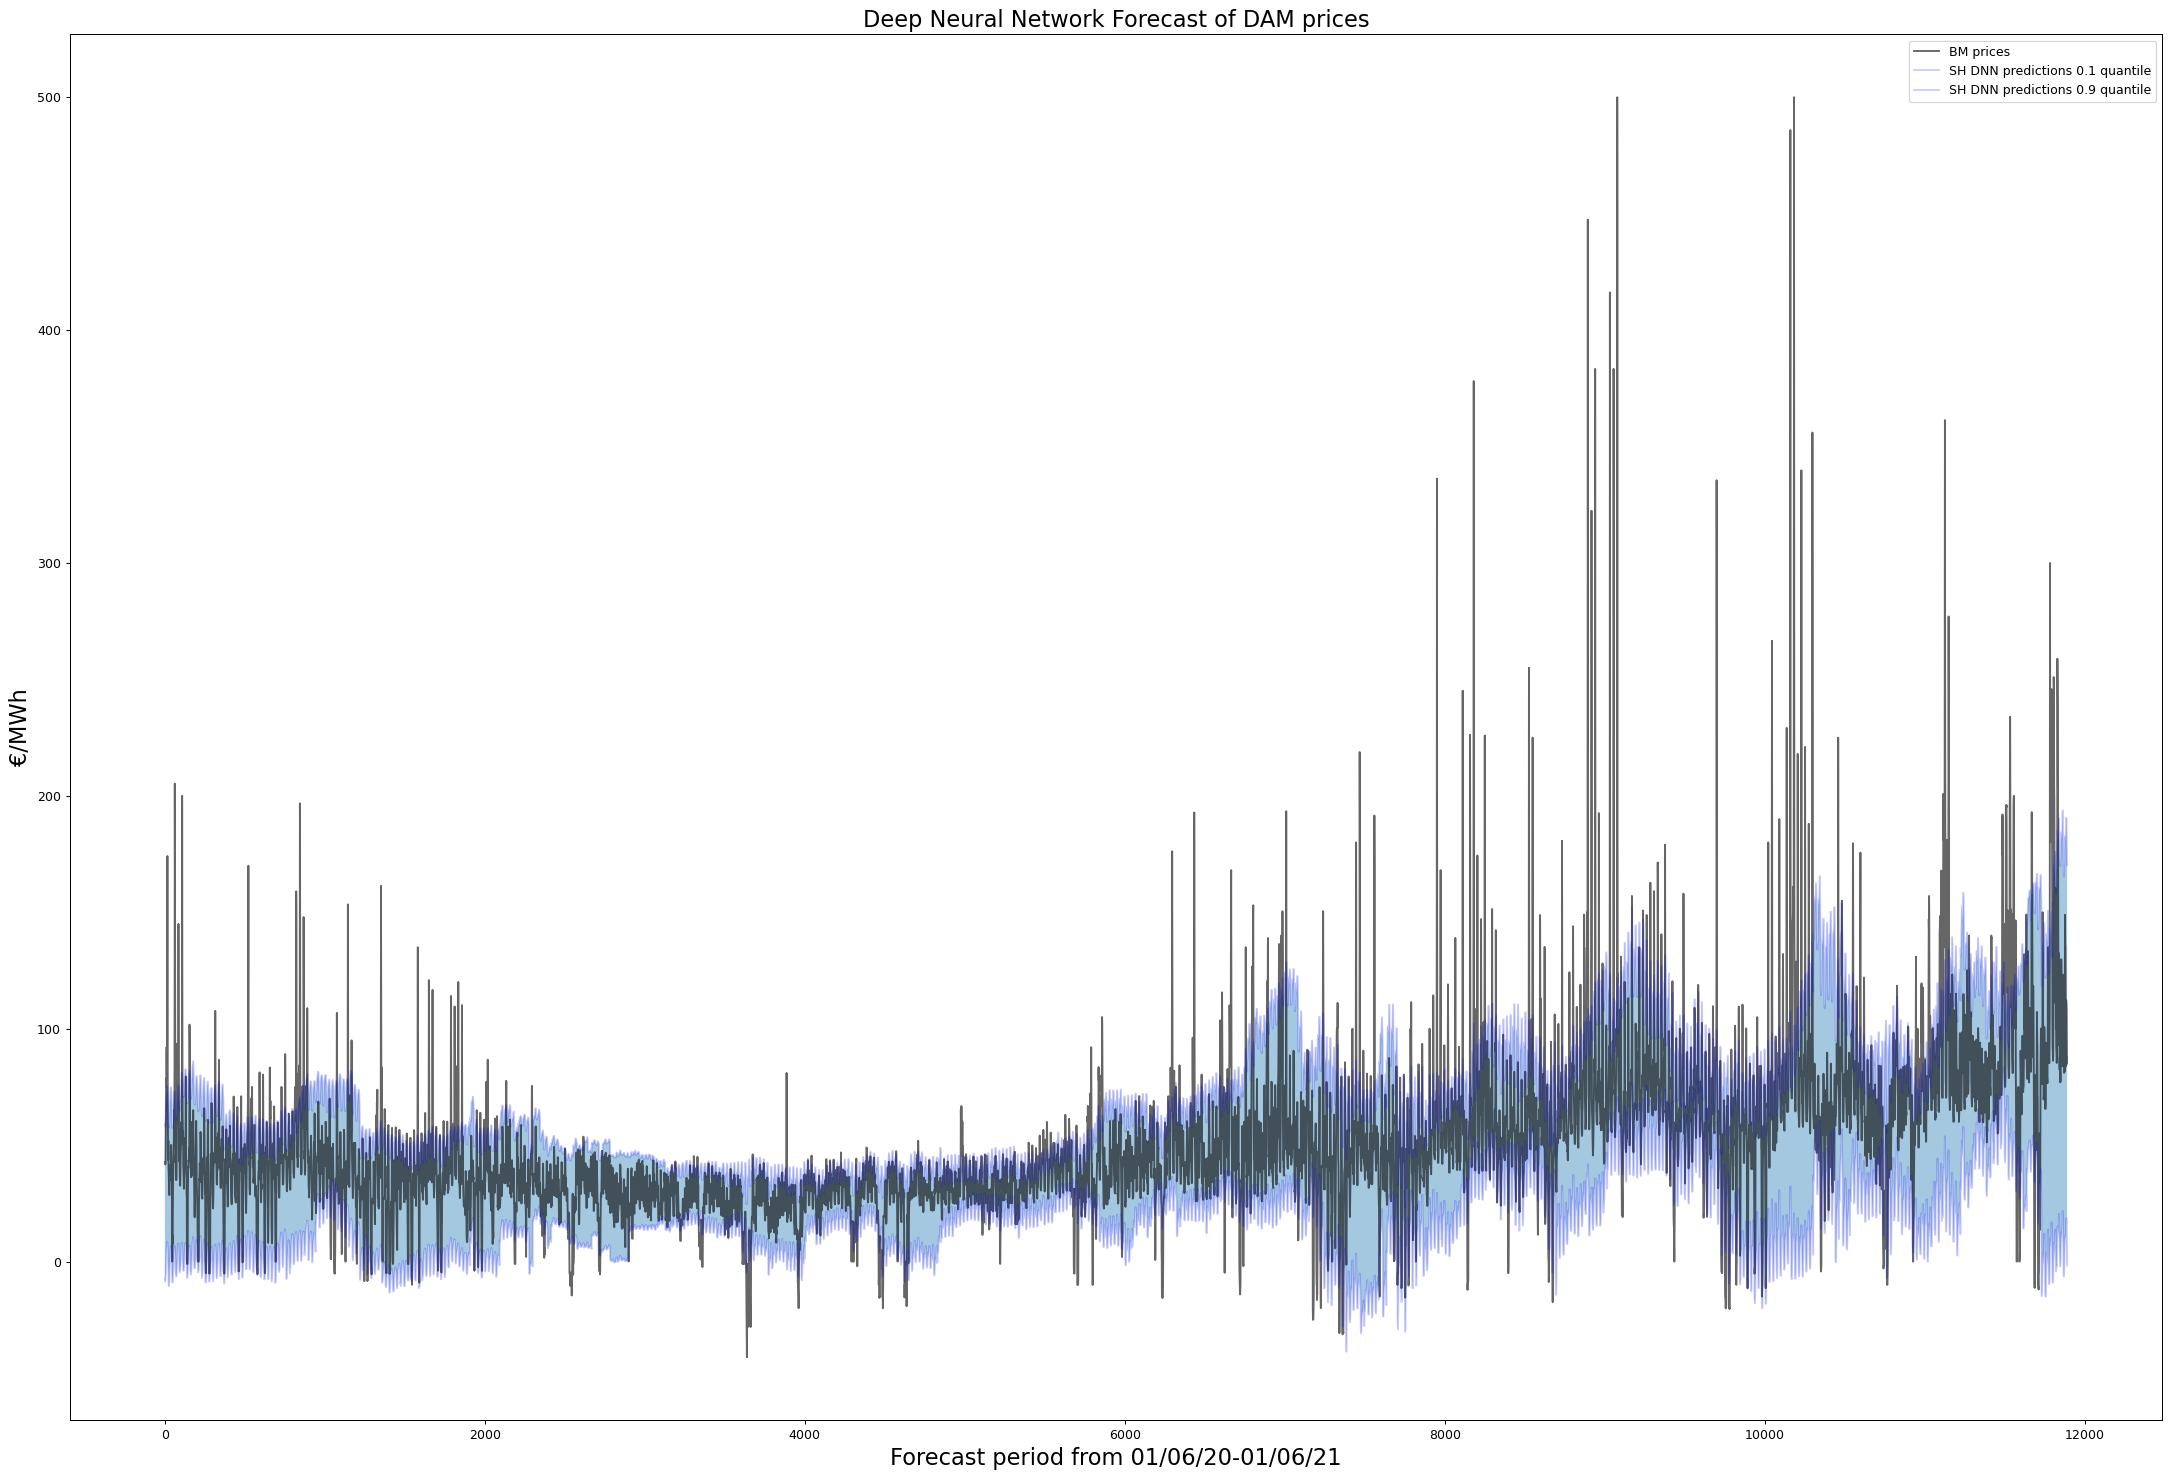

In [27]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/knn_EnbPI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 45.75
RMSE: 37.17
RMSE: 28.89
RMSE: 26.26
RMSE: 40.24
RMSE: 35.66

Performance Metrics for Quantile MAE:
MAE: 34.60
MAE: 24.47
MAE: 15.98
MAE: 15.07
MAE: 27.78
MAE: 23.58

Performance Metrics for Quantile Pinball Score:
Pinball Score: 3.71
Pinball Score: 7.68
Pinball Score: 7.99
Pinball Score: 6.63
Pinball Score: 4.43
Pinball Score: 6.09

Performance Metrics for Quantile sMAPE:
sMAPE: 92.57
sMAPE: 54.11
sMAPE: nan
sMAPE: 31.63
sMAPE: 46.32
sMAPE: 56.16

Performance Metrics for Quantile Winkler Score:
Winkler Score: 56.91
Winkler Score: 47.63
Winkler Score: 63.93
Winkler Score: 167.09
Winkler Score: 149.98
Winkler Score: 56.16

Performance Metrics for Quantile Mean Width:
Mean Width: 57.61
Mean Width: 27.30
Mean Width: 0.00
Mean Width: 27.30
Mean Width: 57.61
Mean Width: 42.45

Performance Metrics for Quantile coverage:
coverage: 0.88
coverage: 0.63
coverage: 0.75
coverage: 0.00
coverage: 0.00
coverage: 0.75

Total hours that reject the null 

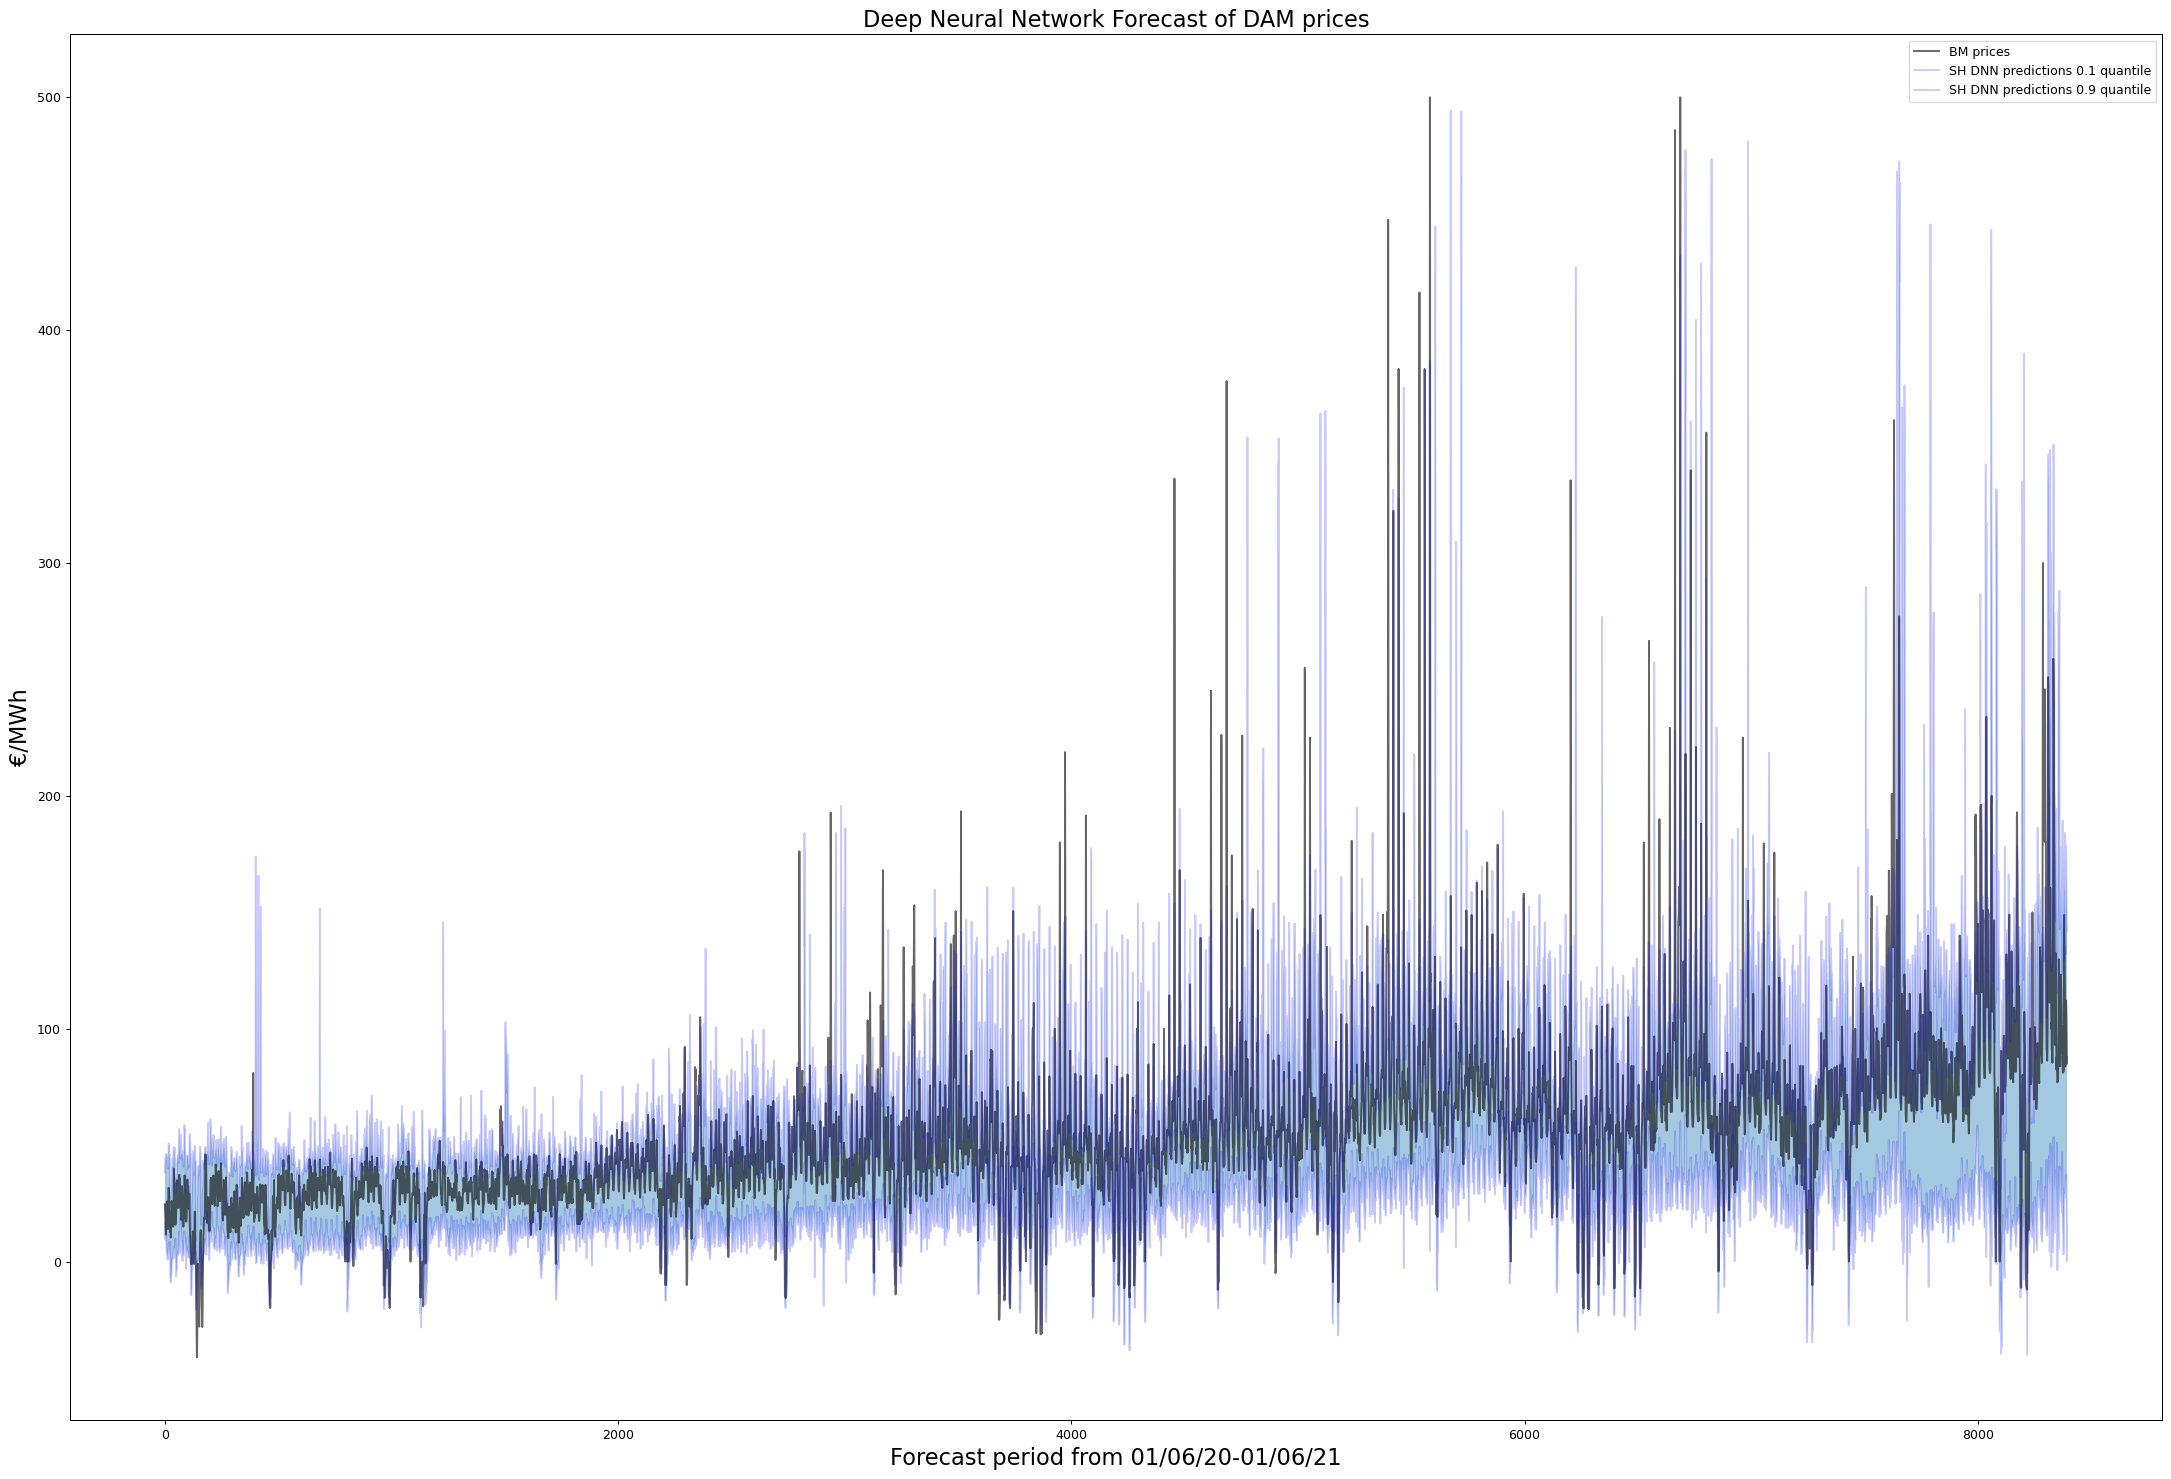

In [28]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/knn_SPCI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

In [29]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Subset_QRA/knn_Q_DAM_QRA_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[121:,:].reset_index(drop=True)


column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ciaran/DAM_QRA/Subset_QRA/knn_Q_DAM_QRA_1-12.csv'

Performance Metrics for Quantile RMSE:
RMSE: 53.14
RMSE: 45.10
RMSE: 18.94
RMSE: 36.53
RMSE: 34.72
RMSE: 37.69

Performance Metrics for Quantile MAE:
MAE: 40.70
MAE: 30.77
MAE: 9.81
MAE: 22.34
MAE: 22.66
MAE: 25.26

Performance Metrics for Quantile Pinball Score:
Pinball Score: 5.01
Pinball Score: 10.21
Pinball Score: 4.91
Pinball Score: 13.11
Pinball Score: 8.50
Pinball Score: 8.35

Performance Metrics for Quantile sMAPE:
sMAPE: 104.23
sMAPE: 64.79
sMAPE: 23.69
sMAPE: 43.22
sMAPE: 43.12
sMAPE: 55.81

Performance Metrics for Quantile Winkler Score:
Winkler Score: 51.09
Winkler Score: 95.57
Winkler Score: 39.24
Winkler Score: 173.28
Winkler Score: 135.99
Winkler Score: 61.97

Performance Metrics for Quantile Mean Width:
Mean Width: 45.43
Mean Width: 16.20
Mean Width: 0.00
Mean Width: 16.20
Mean Width: 45.43
Mean Width: 30.81

Performance Metrics for Quantile coverage:
coverage: 0.65
coverage: 0.23
coverage: 0.53
coverage: 0.00
coverage: 0.00
coverage: 0.47

Total hours that reject the n

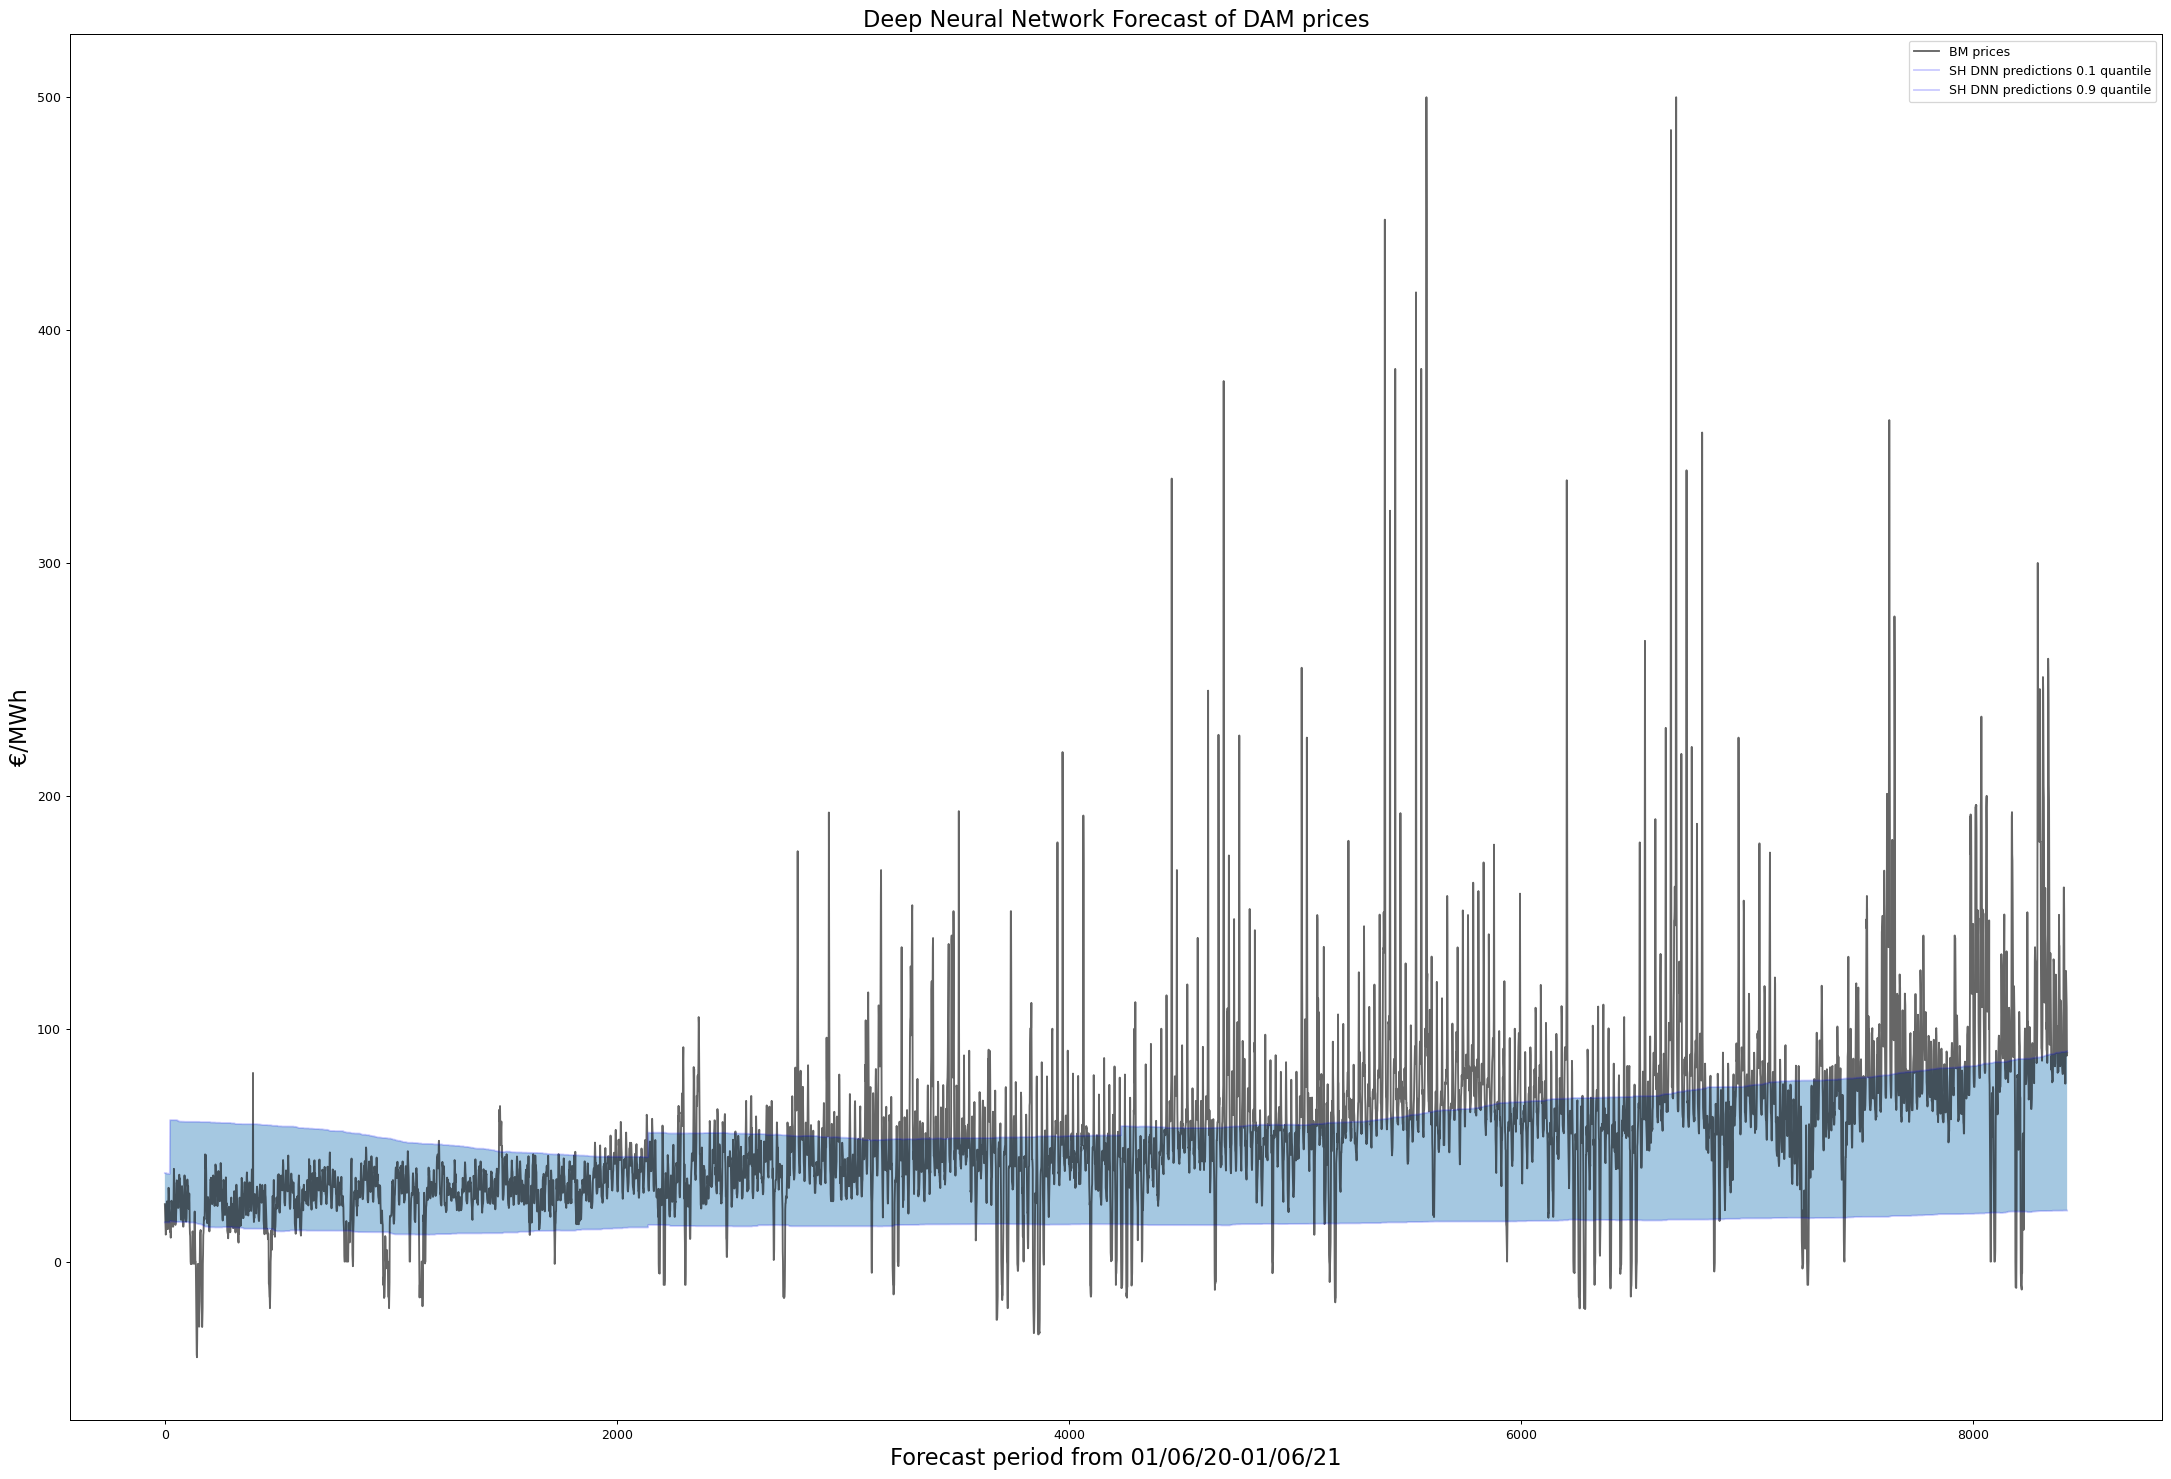

In [30]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/LEAR_Q_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 29.34
RMSE: 22.78
RMSE: 18.95
RMSE: 21.01
RMSE: 28.65
RMSE: 24.15

Performance Metrics for Quantile MAE:
MAE: 21.66
MAE: 14.21
MAE: 9.80
MAE: 13.73
MAE: 21.47
MAE: 16.18

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.58
Pinball Score: 4.79
Pinball Score: 4.90
Pinball Score: 5.15
Pinball Score: 3.46
Pinball Score: 4.18

Performance Metrics for Quantile sMAPE:
sMAPE: 59.22
sMAPE: 36.21
sMAPE: 23.72
sMAPE: 29.30
sMAPE: 39.35
sMAPE: 37.56

Performance Metrics for Quantile Winkler Score:
Winkler Score: 39.71
Winkler Score: 33.20
Winkler Score: 39.20
Winkler Score: 120.27
Winkler Score: 102.44
Winkler Score: 37.37

Performance Metrics for Quantile Mean Width:
Mean Width: 38.82
Mean Width: 20.16
Mean Width: 0.00
Mean Width: 20.16
Mean Width: 38.82
Mean Width: 29.49

Performance Metrics for Quantile coverage:
coverage: 0.88
coverage: 0.67
coverage: 0.53
coverage: 0.00
coverage: 0.00
coverage: 0.69

Total hours that reject the null

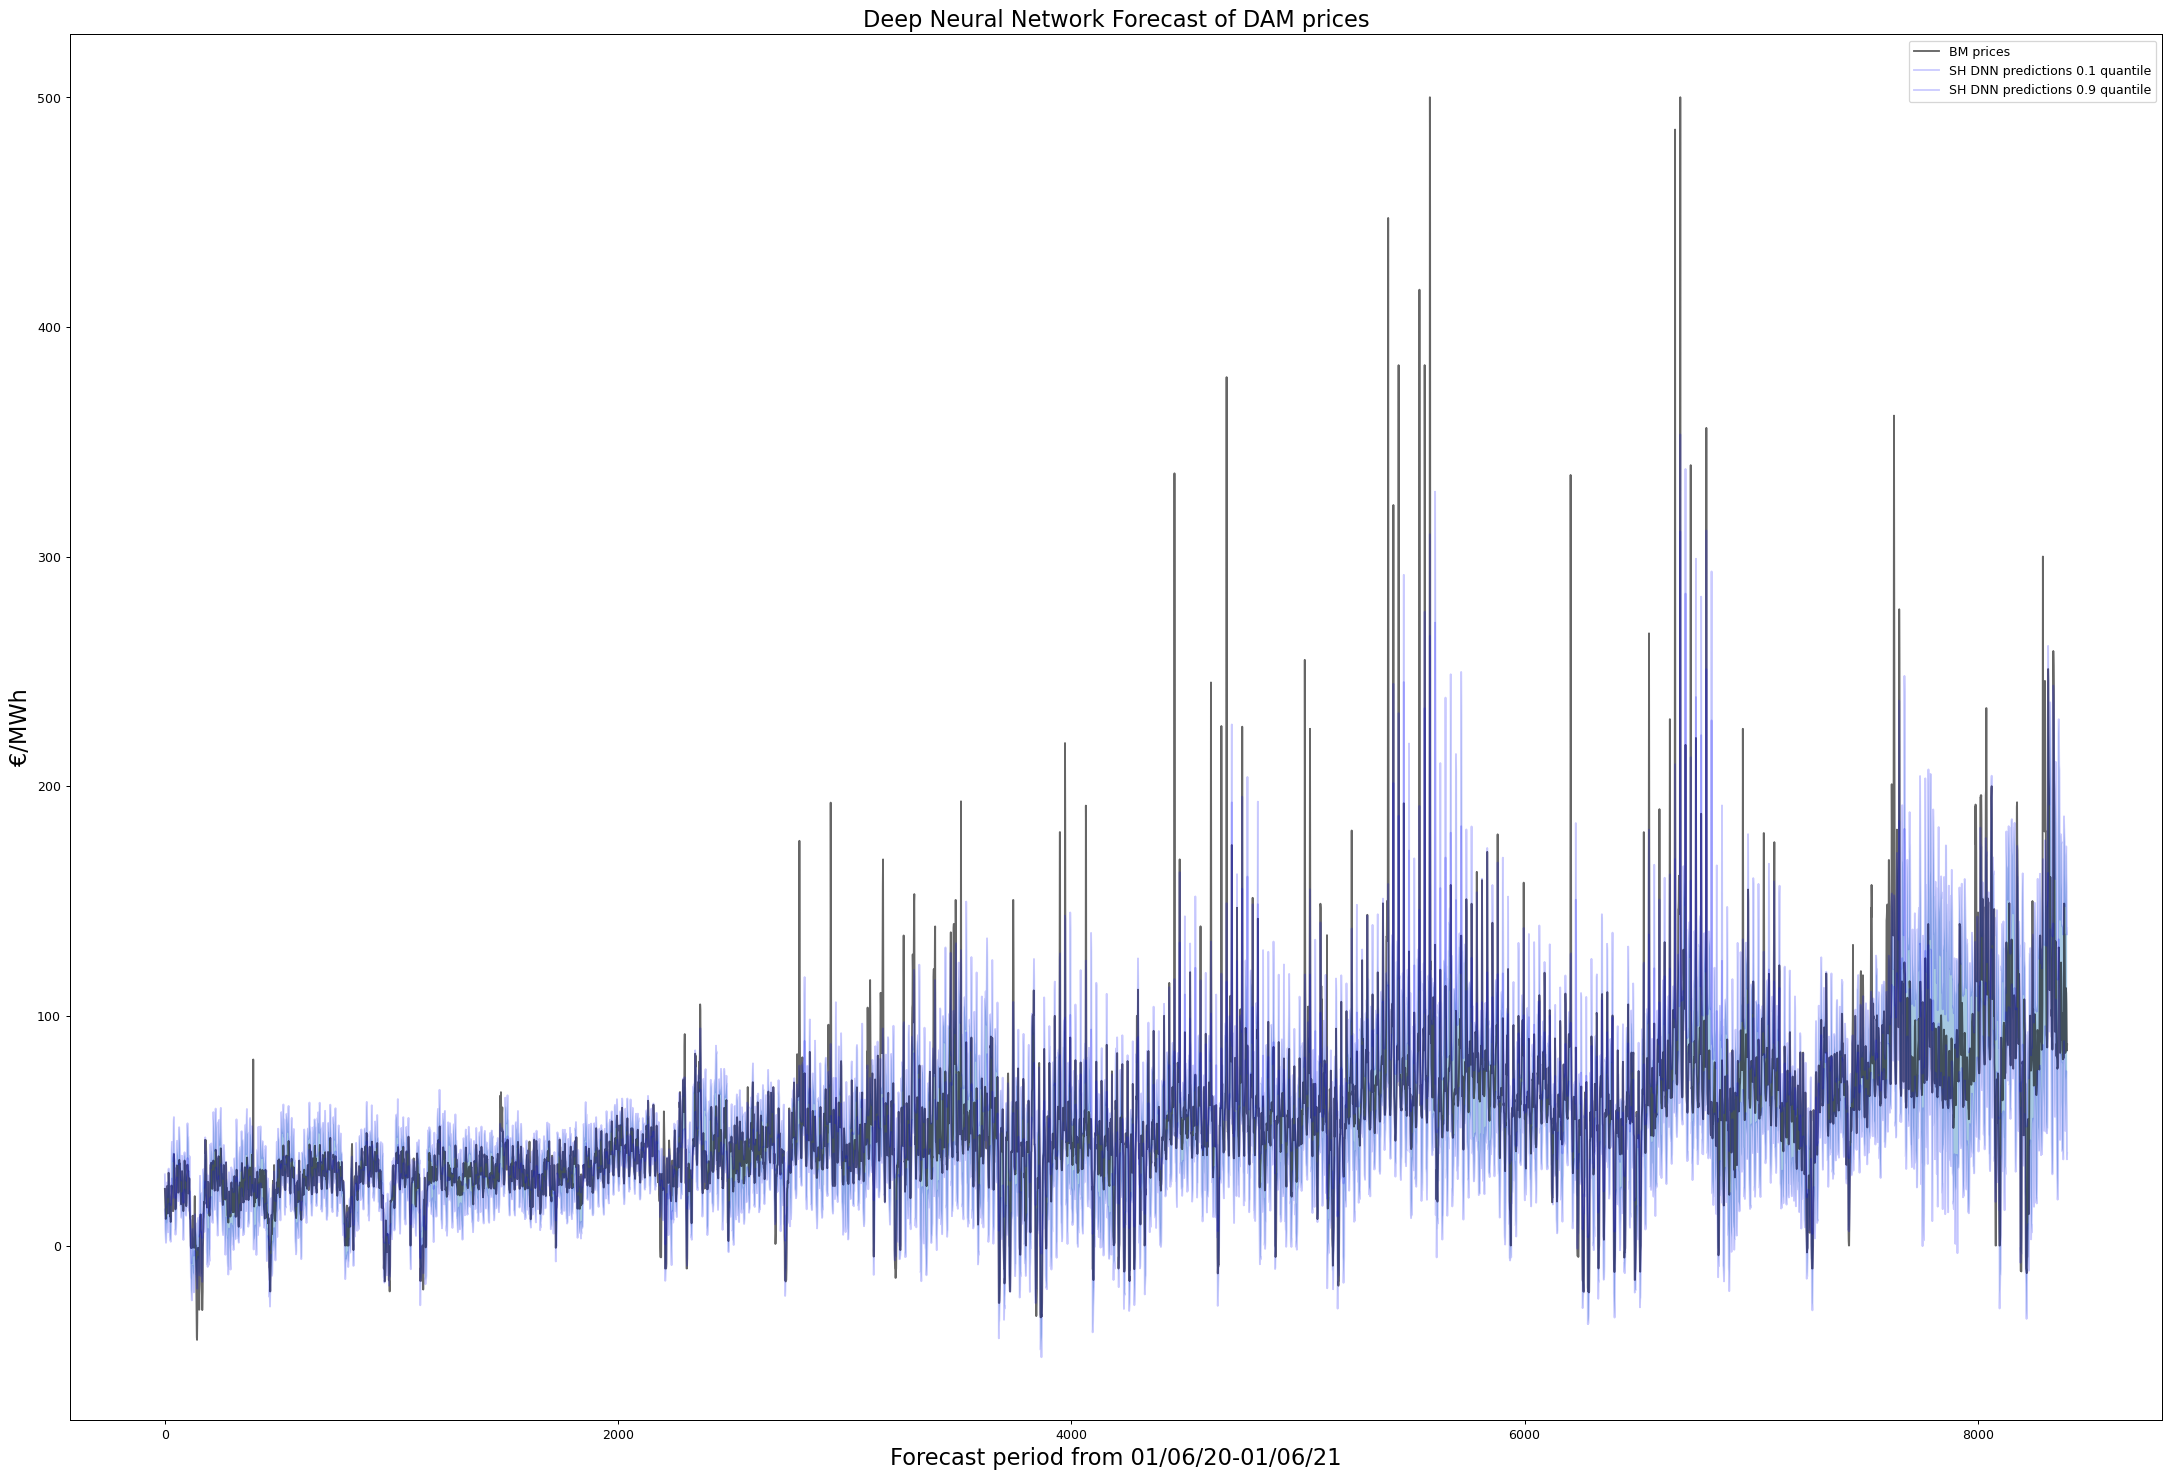

In [31]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/LEAR_EnbPI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 26.90
RMSE: 21.90
RMSE: 18.95
RMSE: 23.38
RMSE: 30.05
RMSE: 24.24

Performance Metrics for Quantile MAE:
MAE: 18.47
MAE: 13.20
MAE: 9.80
MAE: 13.05
MAE: 18.88
MAE: 14.68

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.43
Pinball Score: 4.58
Pinball Score: 4.90
Pinball Score: 5.09
Pinball Score: 3.38
Pinball Score: 4.08

Performance Metrics for Quantile sMAPE:
sMAPE: 51.21
sMAPE: 34.50
sMAPE: 23.72
sMAPE: 27.67
sMAPE: 36.24
sMAPE: 34.67

Performance Metrics for Quantile Winkler Score:
Winkler Score: 33.05
Winkler Score: 32.93
Winkler Score: 39.20
Winkler Score: 108.94
Winkler Score: 86.89
Winkler Score: 35.06

Performance Metrics for Quantile Mean Width:
Mean Width: 32.16
Mean Width: 17.32
Mean Width: 0.00
Mean Width: 17.32
Mean Width: 32.16
Mean Width: 24.74

Performance Metrics for Quantile coverage:
coverage: 0.84
coverage: 0.63
coverage: 0.53
coverage: 0.00
coverage: 0.00
coverage: 0.67

Total hours that reject the null 

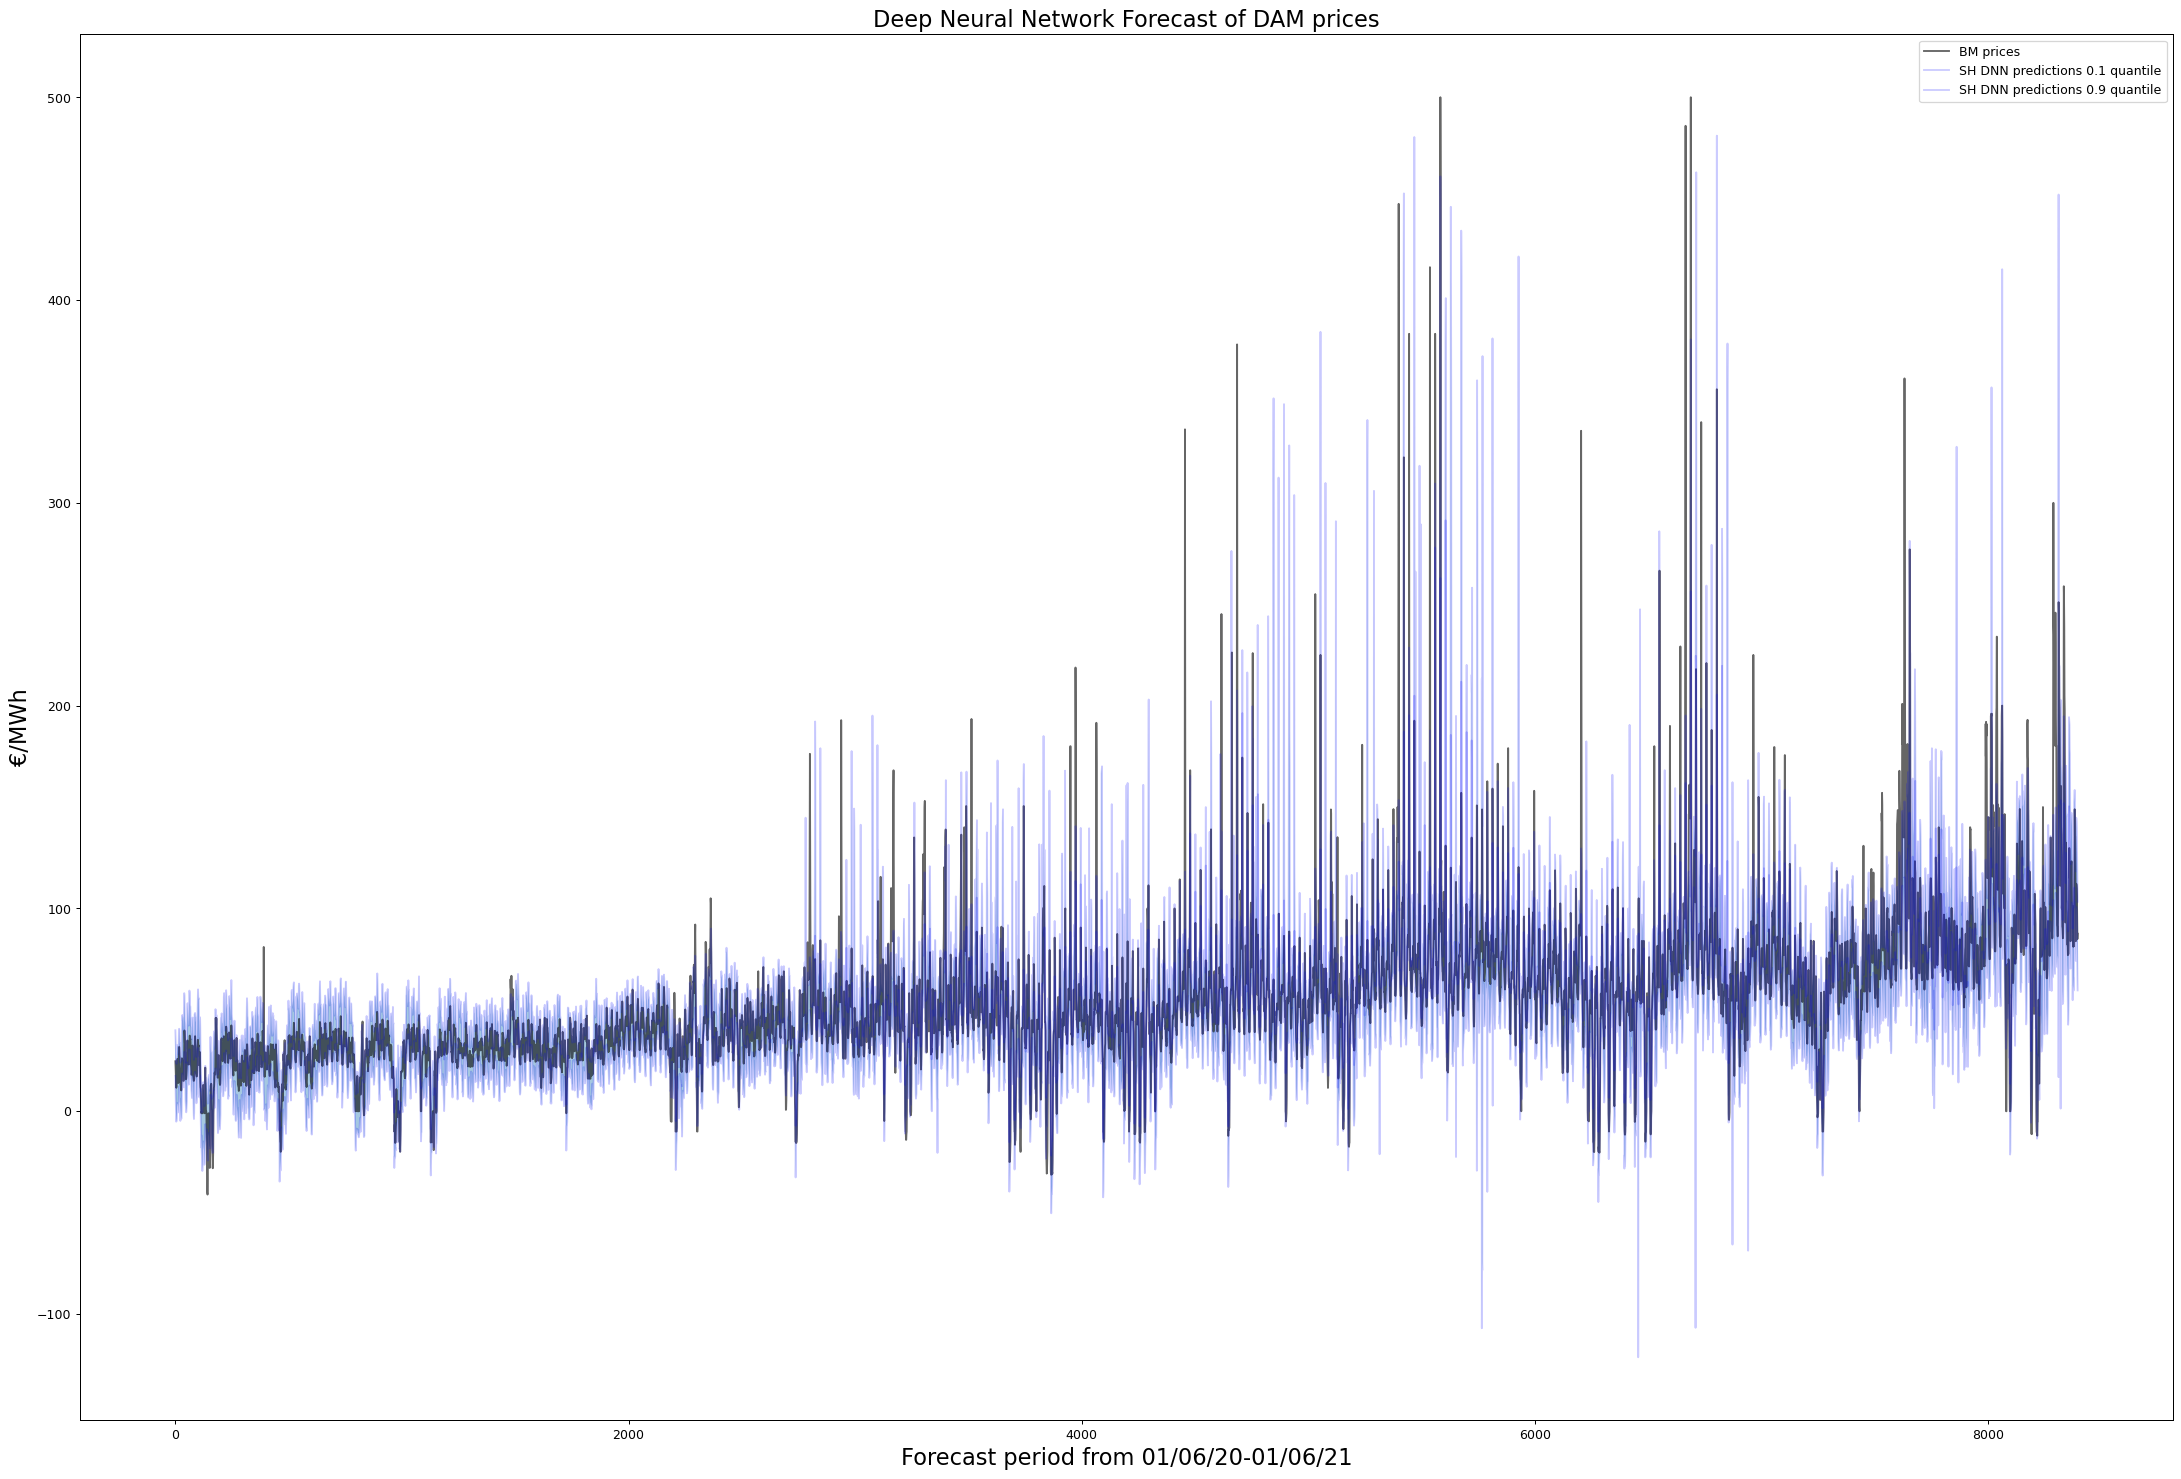

In [32]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/LEAR_SPCI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
# dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

In [33]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Subset_QRA/lasso_Q_DAM_QRA_1-3.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[121:,:].reset_index(drop=True)


column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ciaran/DAM_QRA/Subset_QRA/lasso_Q_DAM_QRA_1-3.csv'

Performance Metrics for Quantile RMSE:
RMSE: 27.08
RMSE: 21.78
RMSE: 18.96
RMSE: 17.83
RMSE: 19.30
RMSE: 20.99

Performance Metrics for Quantile MAE:
MAE: 13.59
MAE: 9.85
MAE: 8.82
MAE: 8.94
MAE: 10.79
MAE: 10.40

Performance Metrics for Quantile Pinball Score:
Pinball Score: 1.94
Pinball Score: 3.61
Pinball Score: 4.41
Pinball Score: 4.57
Pinball Score: 3.59
Pinball Score: 3.62

Performance Metrics for Quantile sMAPE:
sMAPE: 28.97
sMAPE: 22.02
sMAPE: 20.55
sMAPE: 20.83
sMAPE: 24.11
sMAPE: 23.30

Performance Metrics for Quantile Winkler Score:
Winkler Score: 20.28
Winkler Score: 34.05
Winkler Score: 35.29
Winkler Score: 62.27
Winkler Score: 51.27
Winkler Score: 29.87

Performance Metrics for Quantile Mean Width:
Mean Width: 16.65
Mean Width: 6.44
Mean Width: 0.00
Mean Width: 6.44
Mean Width: 16.65
Mean Width: 11.55

Performance Metrics for Quantile coverage:
coverage: 0.54
coverage: 0.22
coverage: 0.58
coverage: 0.01
coverage: 0.00
coverage: 0.45

Total hours that reject the null hypot

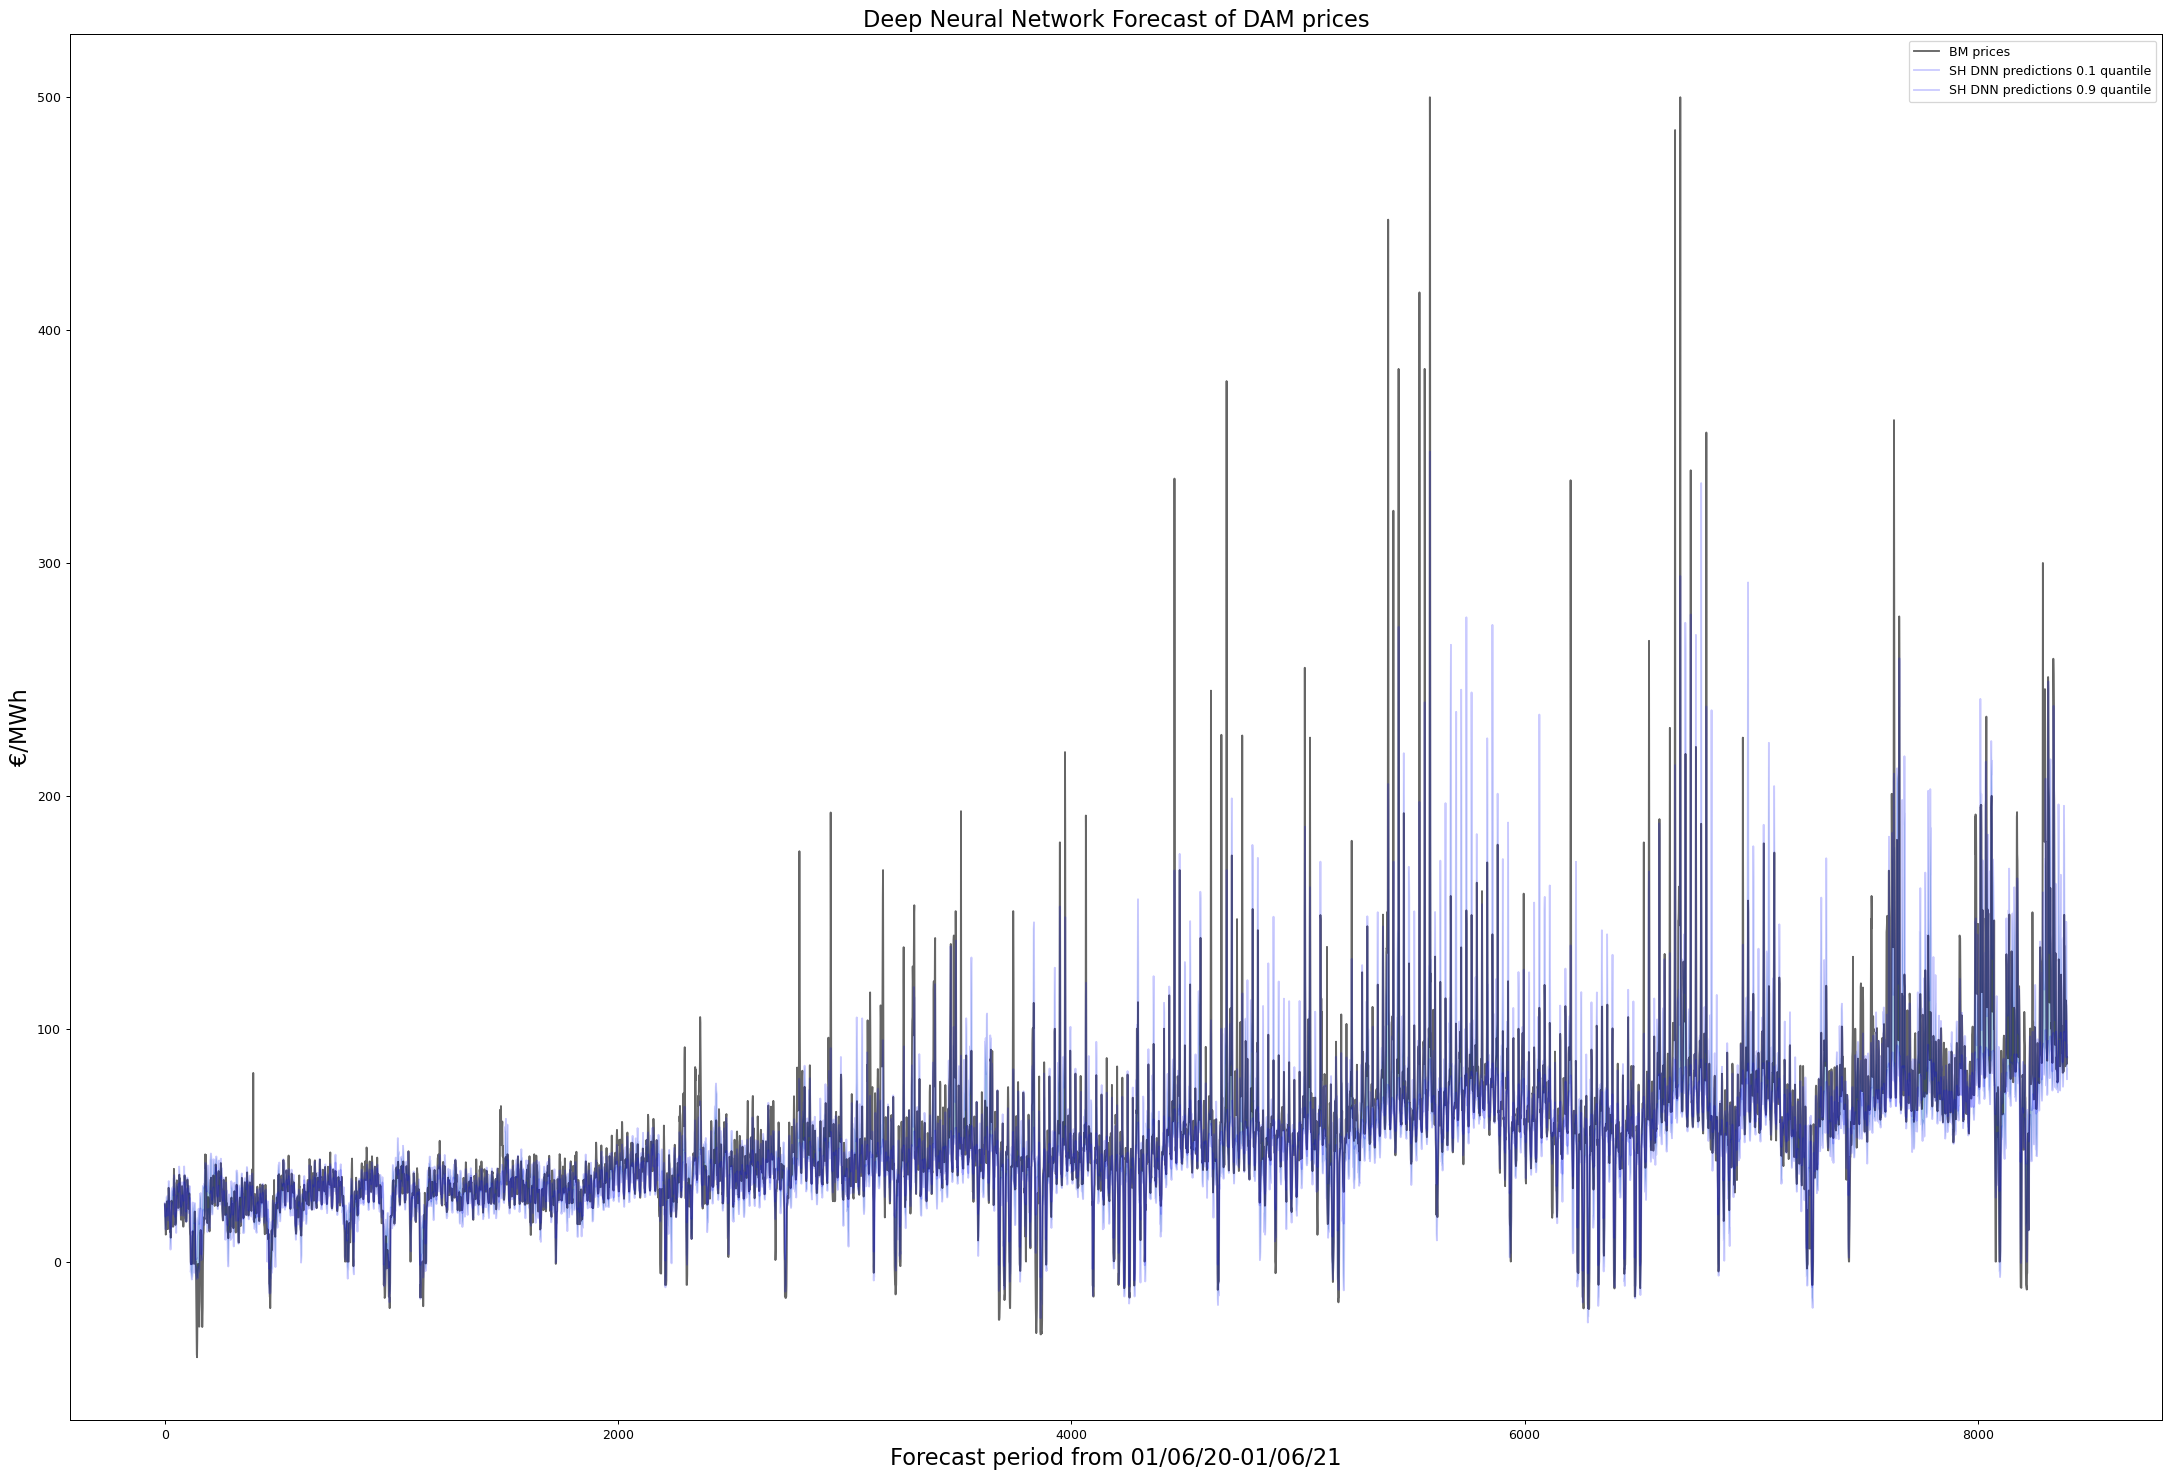

In [34]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/lgbm_Q_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 26.76
RMSE: 22.94
RMSE: 18.96
RMSE: 20.27
RMSE: 24.28
RMSE: 22.64

Performance Metrics for Quantile MAE:
MAE: 17.01
MAE: 11.85
MAE: 8.82
MAE: 10.18
MAE: 16.65
MAE: 12.90

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.07
Pinball Score: 3.97
Pinball Score: 4.41
Pinball Score: 4.68
Pinball Score: 3.67
Pinball Score: 3.76

Performance Metrics for Quantile sMAPE:
sMAPE: 40.64
sMAPE: 26.85
sMAPE: 20.55
sMAPE: 23.58
sMAPE: 33.79
sMAPE: 29.08

Performance Metrics for Quantile Winkler Score:
Winkler Score: 30.70
Winkler Score: 32.29
Winkler Score: 35.29
Winkler Score: 84.63
Winkler Score: 76.72
Winkler Score: 32.76

Performance Metrics for Quantile Mean Width:
Mean Width: 27.72
Mean Width: 11.82
Mean Width: 0.00
Mean Width: 11.82
Mean Width: 27.72
Mean Width: 19.77

Performance Metrics for Quantile coverage:
coverage: 0.82
coverage: 0.56
coverage: 0.58
coverage: 0.00
coverage: 0.00
coverage: 0.65

Total hours that reject the null h

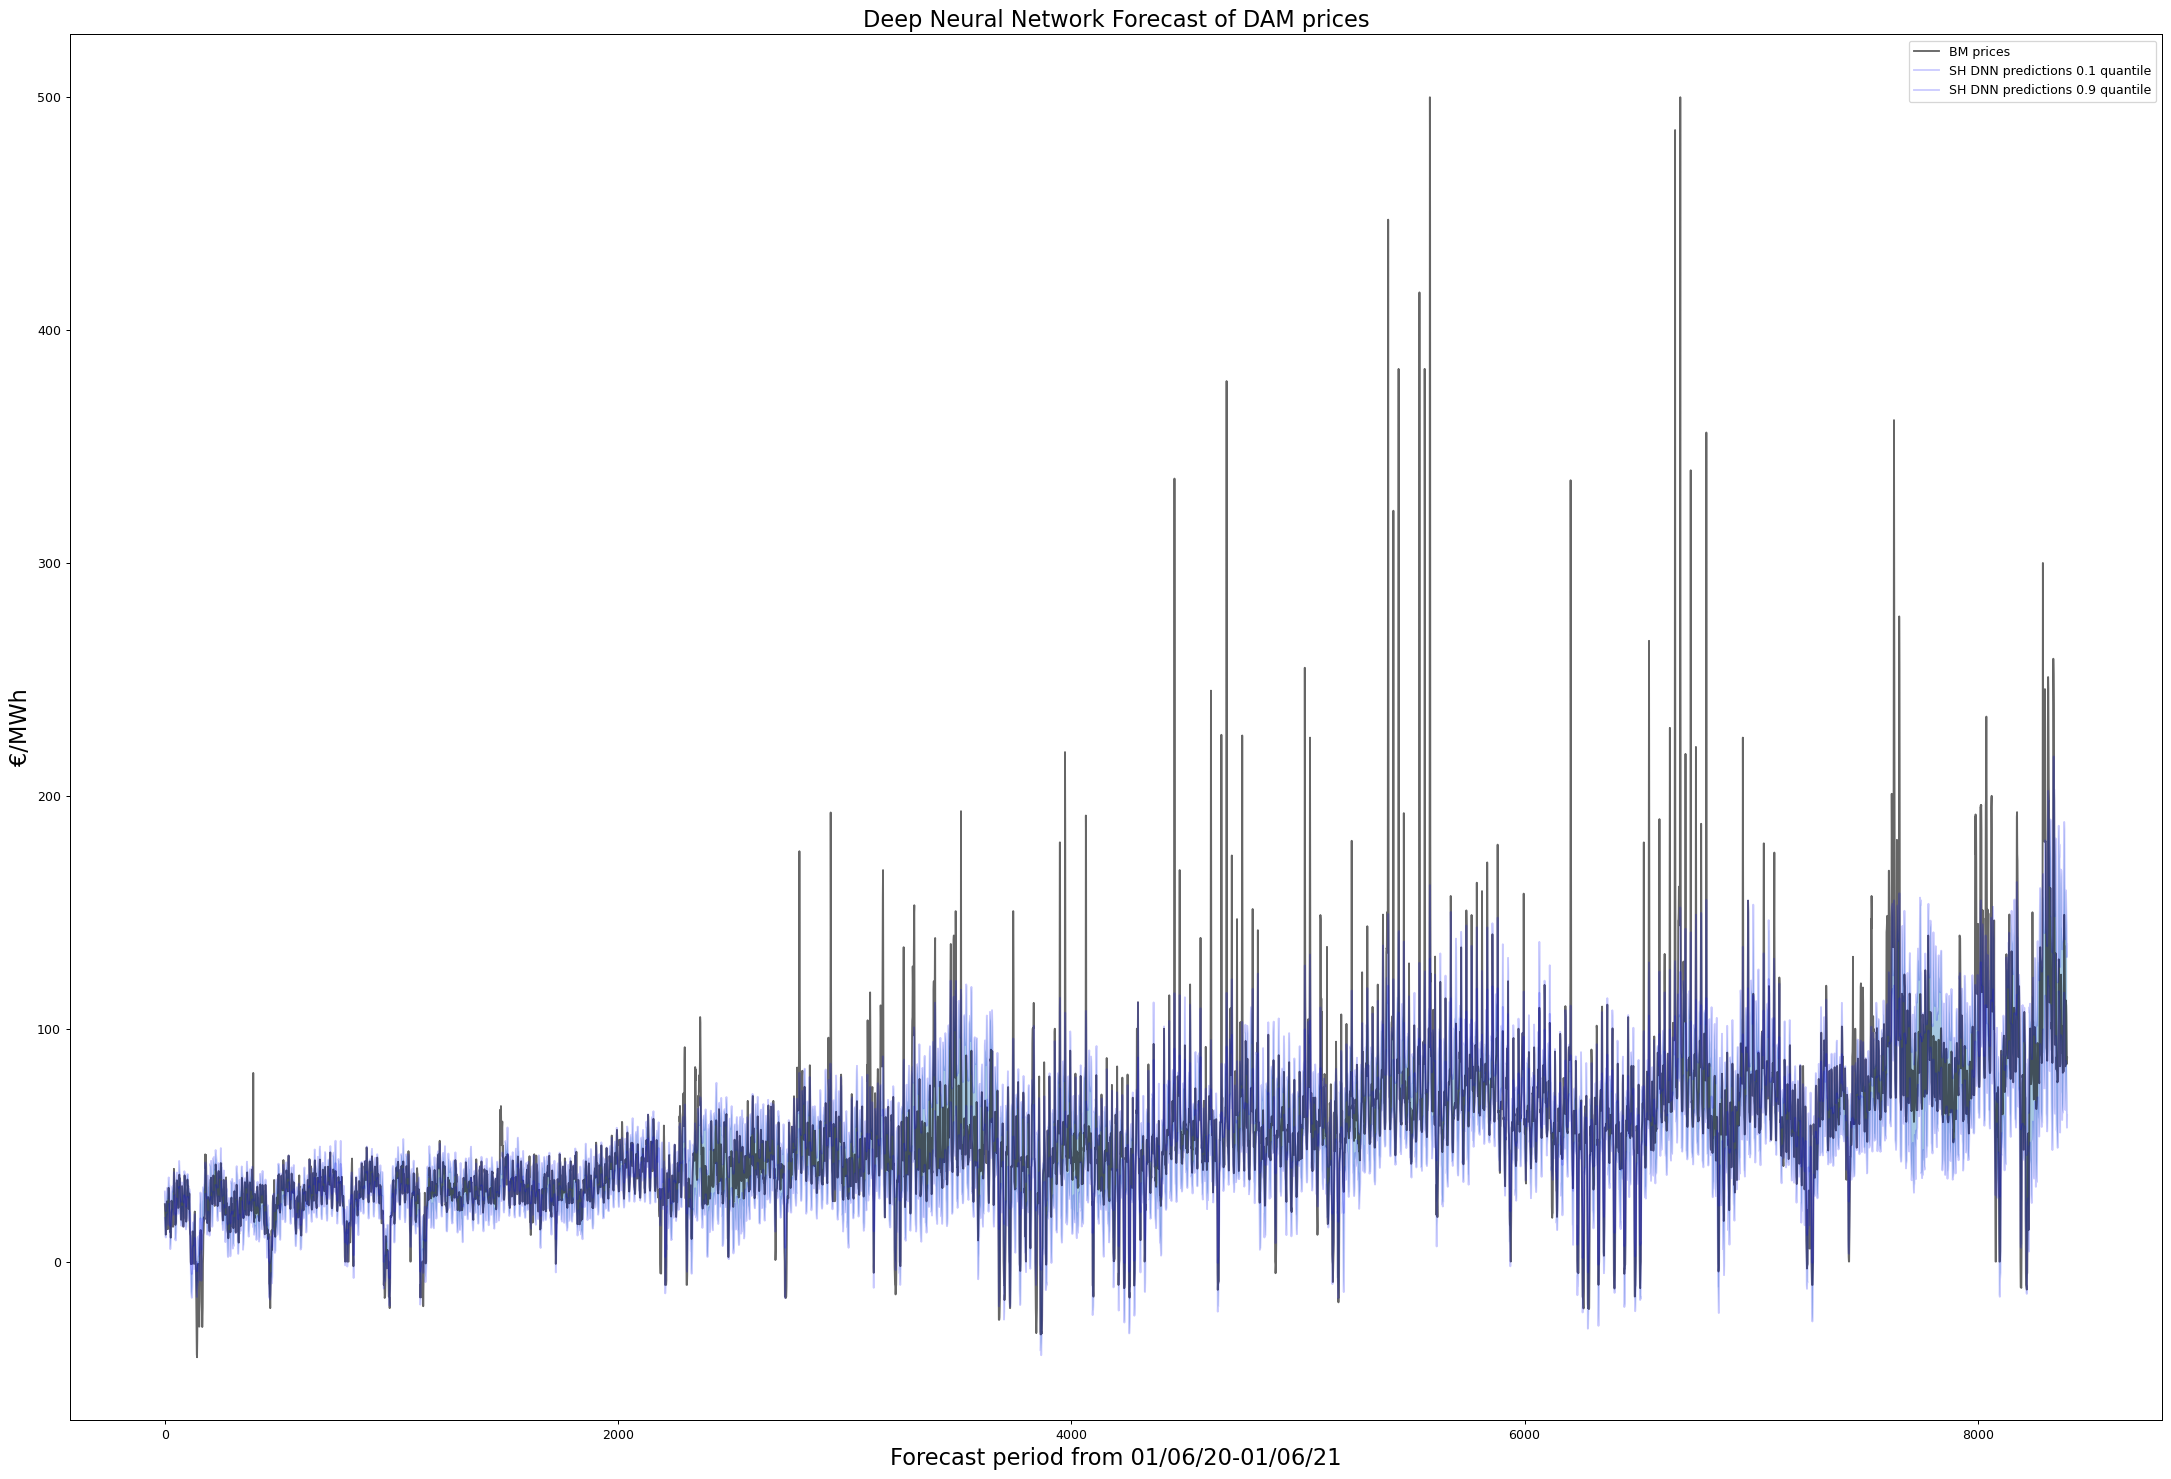

In [35]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/lgbm_EnbPI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 25.13
RMSE: 22.58
RMSE: 18.96
RMSE: 23.14
RMSE: 29.15
RMSE: 23.79

Performance Metrics for Quantile MAE:
MAE: 15.31
MAE: 11.55
MAE: 8.82
MAE: 10.25
MAE: 14.60
MAE: 12.11

Performance Metrics for Quantile Pinball Score:
Pinball Score: 1.92
Pinball Score: 3.88
Pinball Score: 4.41
Pinball Score: 4.76
Pinball Score: 3.57
Pinball Score: 3.71

Performance Metrics for Quantile sMAPE:
sMAPE: 37.39
sMAPE: 26.78
sMAPE: 20.55
sMAPE: 22.76
sMAPE: 29.76
sMAPE: 27.45

Performance Metrics for Quantile Winkler Score:
Winkler Score: 26.36
Winkler Score: 32.28
Winkler Score: 35.29
Winkler Score: 82.74
Winkler Score: 66.98
Winkler Score: 31.31

Performance Metrics for Quantile Mean Width:
Mean Width: 23.67
Mean Width: 11.29
Mean Width: 0.00
Mean Width: 11.29
Mean Width: 23.67
Mean Width: 17.48

Performance Metrics for Quantile coverage:
coverage: 0.78
coverage: 0.51
coverage: 0.58
coverage: 0.00
coverage: 0.00
coverage: 0.63

Total hours that reject the null h

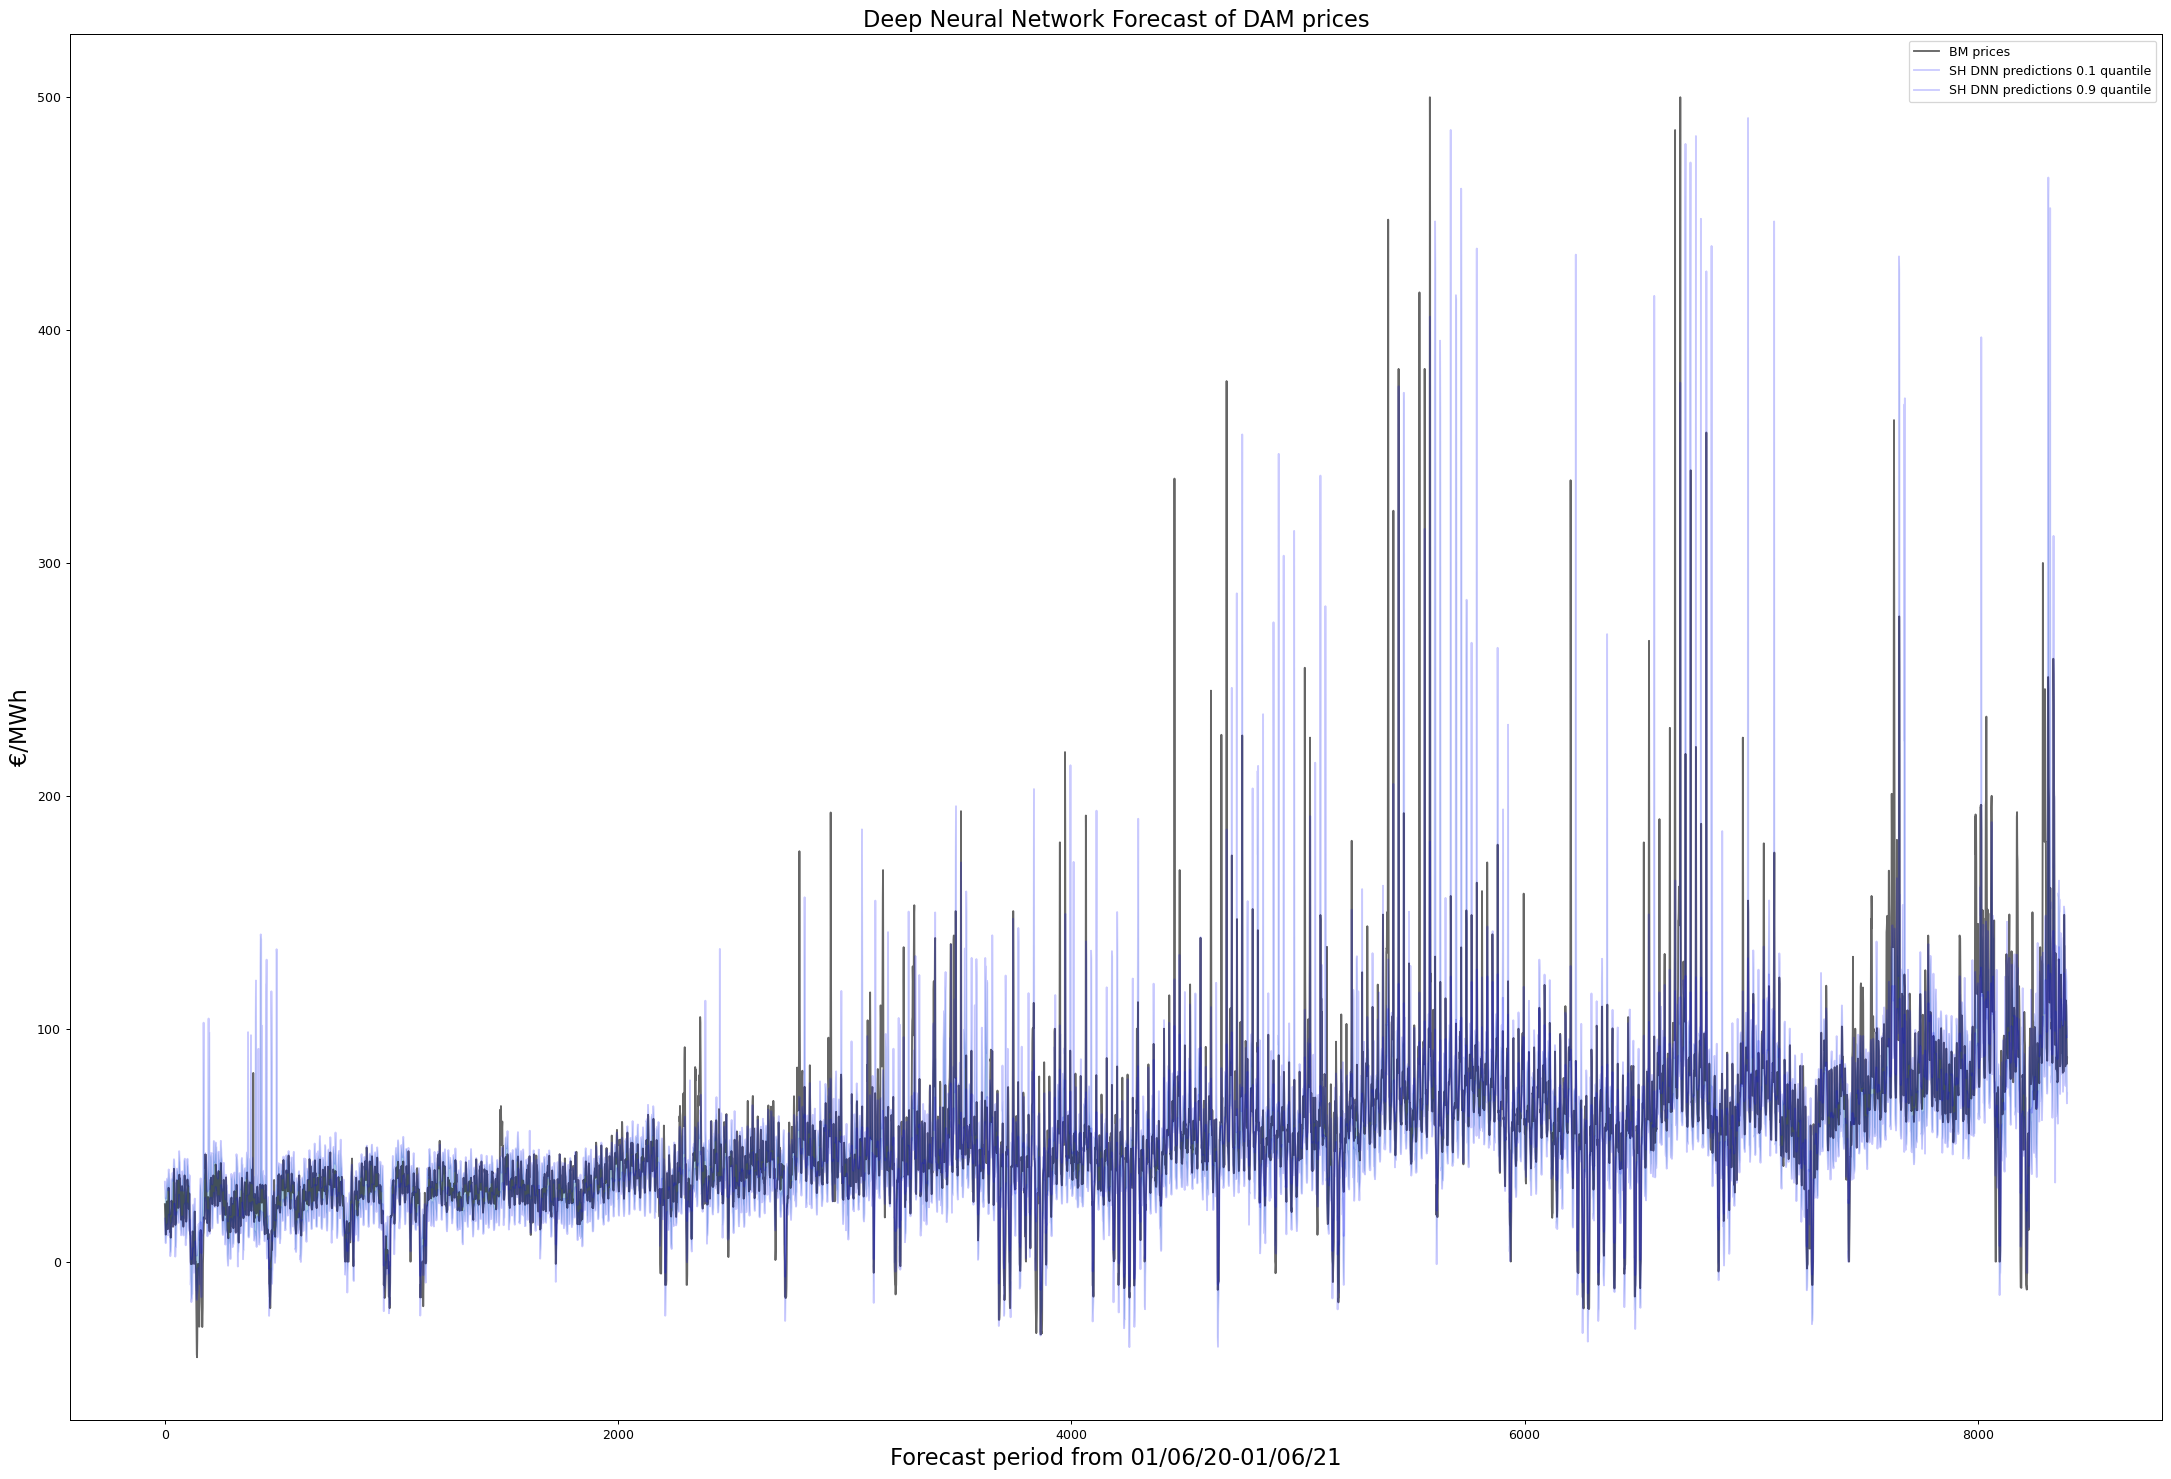

In [36]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/lgbm_SPCI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

In [ ]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Subset_QRA/lgbm_Q_DAM_QRA_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[121:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 29.98
RMSE: 23.75
RMSE: 20.06
RMSE: 18.97
RMSE: 29.83
RMSE: 24.52

Performance Metrics for Quantile MAE:
MAE: 18.91
MAE: 12.33
MAE: 9.58
MAE: 9.69
MAE: 17.44
MAE: 13.59

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.06
Pinball Score: 4.06
Pinball Score: 4.79
Pinball Score: 4.49
Pinball Score: 2.73
Pinball Score: 3.63

Performance Metrics for Quantile sMAPE:
sMAPE: nan
sMAPE: nan
sMAPE: nan
sMAPE: nan
sMAPE: 32.23
sMAPE: 32.23

Performance Metrics for Quantile Winkler Score:
Winkler Score: 32.44
Winkler Score: 30.34
Winkler Score: 38.32
Winkler Score: 85.87
Winkler Score: 87.25
Winkler Score: 33.70

Performance Metrics for Quantile Mean Width:
Mean Width: 33.45
Mean Width: 12.33
Mean Width: 0.00
Mean Width: 12.33
Mean Width: 33.45
Mean Width: 22.89

Performance Metrics for Quantile coverage:
coverage: 0.86
coverage: 0.47
coverage: 0.64
coverage: 0.00
coverage: 0.00
coverage: 0.66

Total hours that reject the null hypothesis

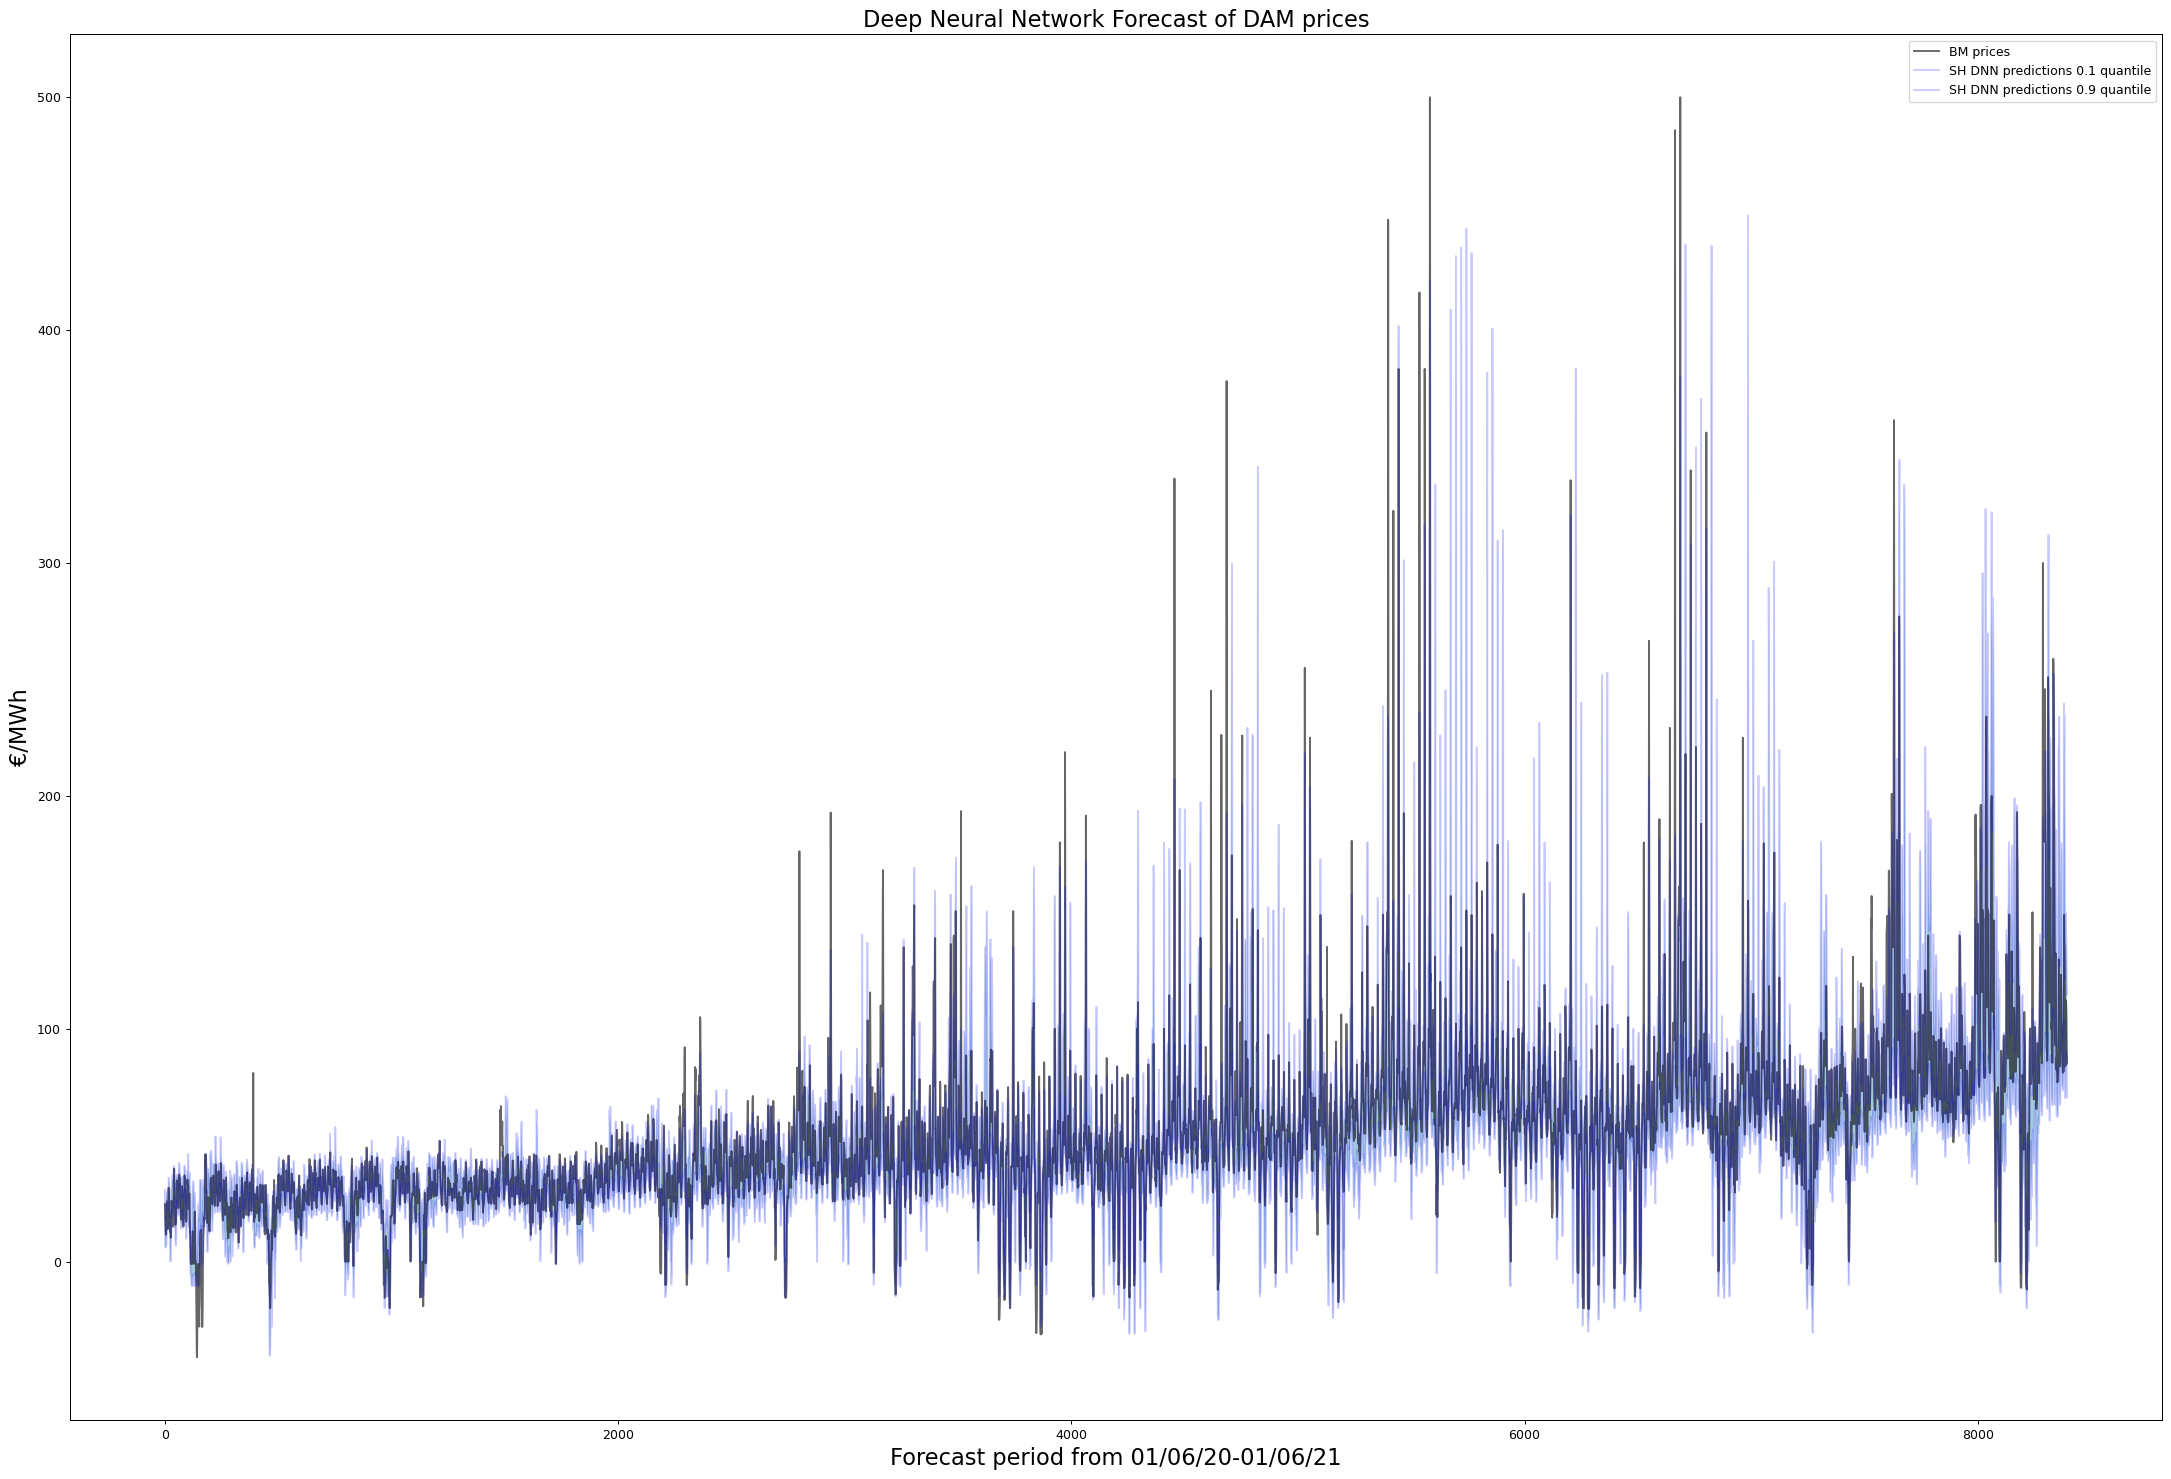

In [37]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/rf_Q_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 23.49
RMSE: 20.36
RMSE: 20.06
RMSE: 18.87
RMSE: 20.84
RMSE: 20.72

Performance Metrics for Quantile MAE:
MAE: 15.17
MAE: 11.20
MAE: 9.58
MAE: 10.10
MAE: 13.54
MAE: 11.92

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.26
Pinball Score: 4.11
Pinball Score: 4.79
Pinball Score: 4.55
Pinball Score: 3.36
Pinball Score: 3.81

Performance Metrics for Quantile sMAPE:
sMAPE: 36.89
sMAPE: 26.56
sMAPE: nan
sMAPE: 23.63
sMAPE: 29.21
sMAPE: 29.07

Performance Metrics for Quantile Winkler Score:
Winkler Score: 25.08
Winkler Score: 33.01
Winkler Score: 38.32
Winkler Score: 78.15
Winkler Score: 63.21
Winkler Score: 32.14

Performance Metrics for Quantile Mean Width:
Mean Width: 21.85
Mean Width: 9.96
Mean Width: 0.00
Mean Width: 9.96
Mean Width: 21.85
Mean Width: 15.91

Performance Metrics for Quantile coverage:
coverage: 0.75
coverage: 0.46
coverage: 0.64
coverage: 0.00
coverage: 0.00
coverage: 0.62

Total hours that reject the null hypot

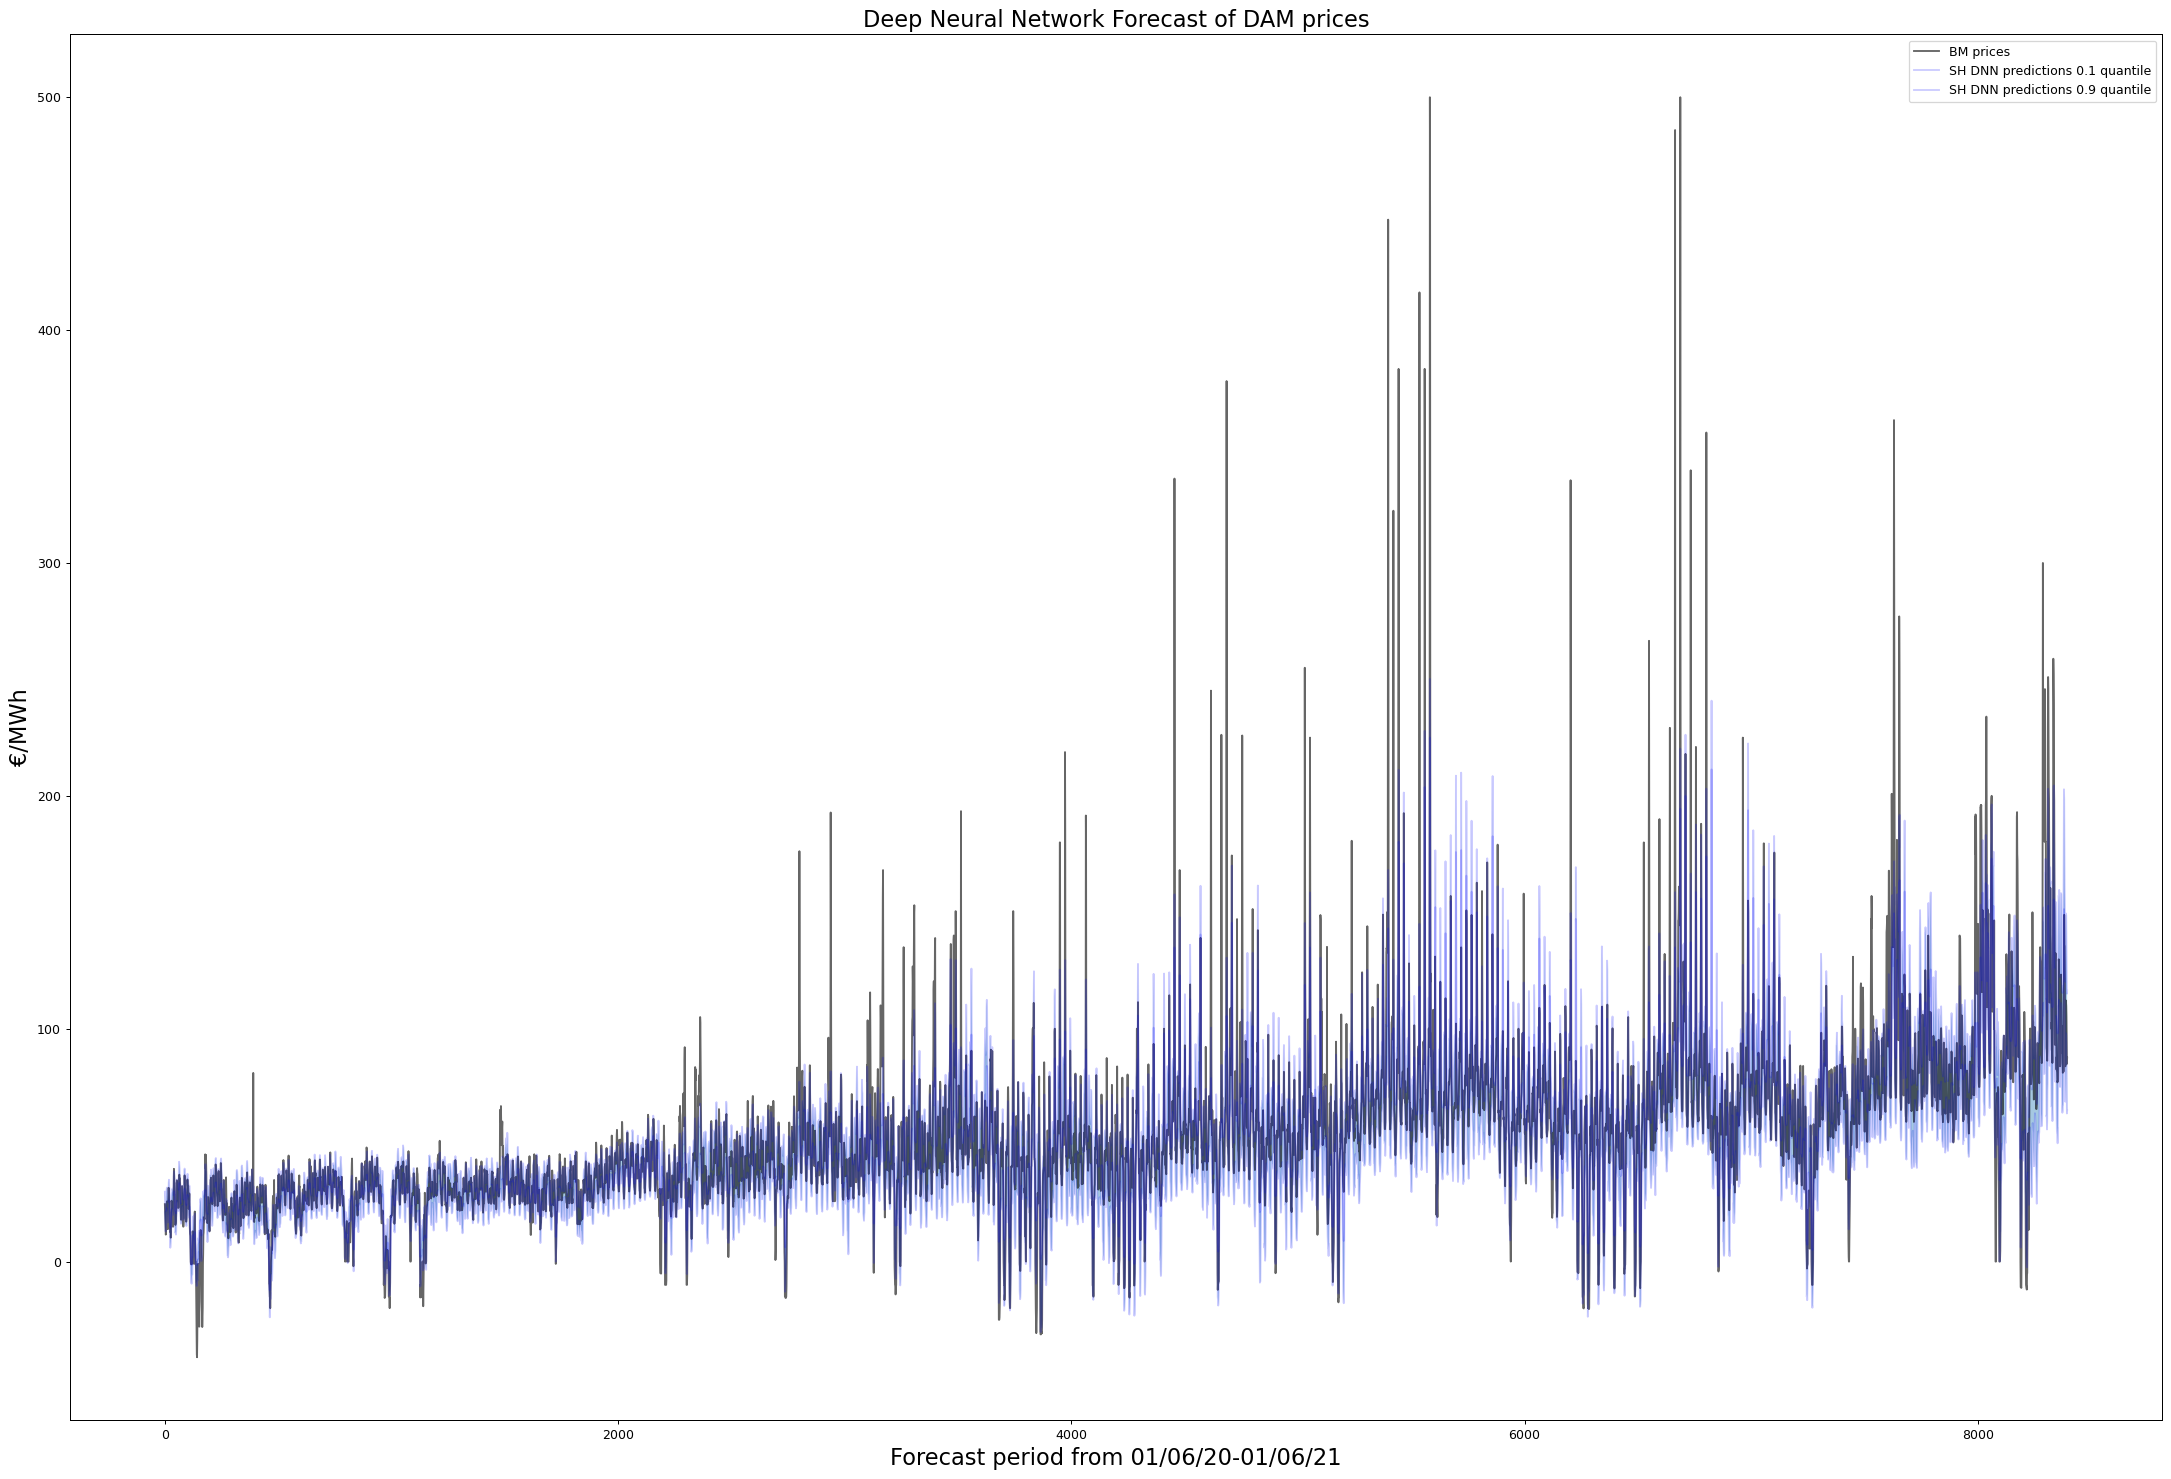

In [38]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/rf_EnbPI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 22.84
RMSE: 20.48
RMSE: 20.06
RMSE: 21.38
RMSE: 25.07
RMSE: 21.97

Performance Metrics for Quantile MAE:
MAE: 14.46
MAE: 11.31
MAE: 9.58
MAE: 10.26
MAE: 13.26
MAE: 11.77

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.25
Pinball Score: 4.10
Pinball Score: 4.79
Pinball Score: 4.70
Pinball Score: 3.38
Pinball Score: 3.84

Performance Metrics for Quantile sMAPE:
sMAPE: 35.63
sMAPE: 26.96
sMAPE: nan
sMAPE: 23.40
sMAPE: 28.37
sMAPE: 28.59

Performance Metrics for Quantile Winkler Score:
Winkler Score: 23.15
Winkler Score: 33.50
Winkler Score: 38.32
Winkler Score: 78.75
Winkler Score: 60.34
Winkler Score: 31.65

Performance Metrics for Quantile Mean Width:
Mean Width: 20.56
Mean Width: 9.93
Mean Width: 0.00
Mean Width: 9.93
Mean Width: 20.56
Mean Width: 15.25

Performance Metrics for Quantile coverage:
coverage: 0.71
coverage: 0.45
coverage: 0.64
coverage: 0.00
coverage: 0.00
coverage: 0.60

Total hours that reject the null hypot

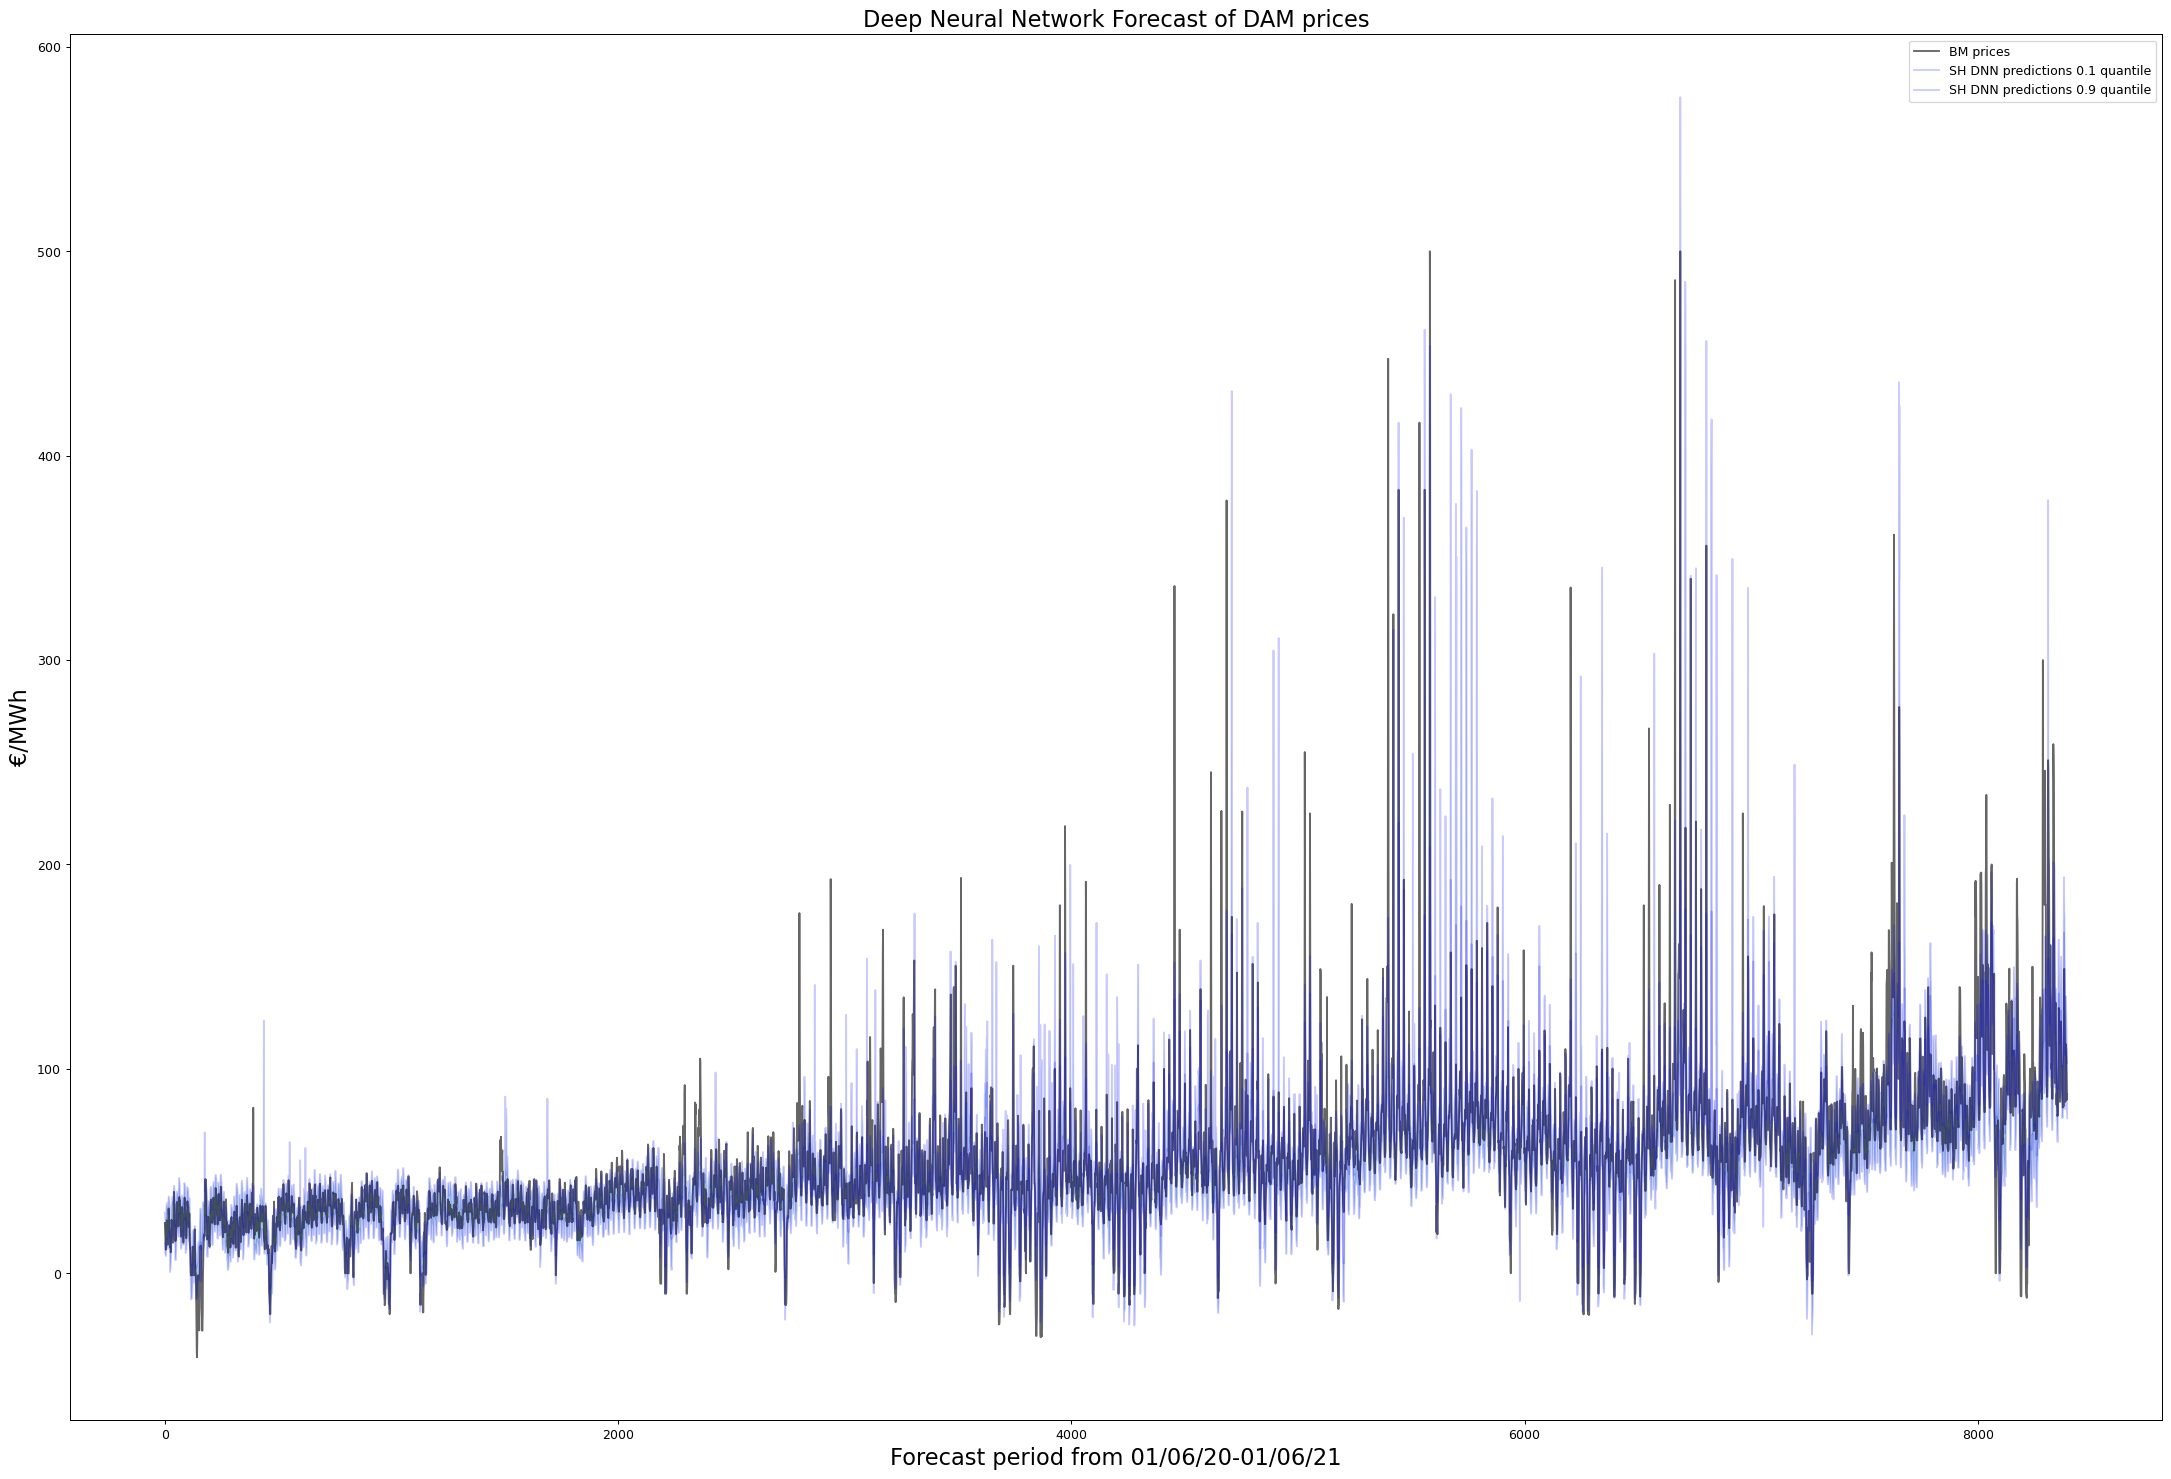

In [39]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/rf_SPCI_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

In [ ]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Subset_QRA/rf_Q_DAM_QRA_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[121:,:].reset_index(drop=True)


column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 28.59
RMSE: 24.39
RMSE: 22.40
RMSE: 22.77
RMSE: 29.92
RMSE: 25.61

Performance Metrics for Quantile MAE:
MAE: 17.20
MAE: 13.47
MAE: 12.10
MAE: 12.52
MAE: 16.70
MAE: 14.40

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.31
Pinball Score: 4.84
Pinball Score: 6.05
Pinball Score: 6.20
Pinball Score: 4.26
Pinball Score: 4.73

Performance Metrics for Quantile sMAPE:
sMAPE: 40.74
sMAPE: 30.59
sMAPE: 26.78
sMAPE: 26.46
sMAPE: 31.04
sMAPE: 31.12

Performance Metrics for Quantile Winkler Score:
Winkler Score: 27.79
Winkler Score: 44.08
Winkler Score: 48.40
Winkler Score: 89.45
Winkler Score: 74.80
Winkler Score: 40.09

Performance Metrics for Quantile Mean Width:
Mean Width: 25.94
Mean Width: 9.92
Mean Width: 0.00
Mean Width: 9.92
Mean Width: 25.94
Mean Width: 17.93

Performance Metrics for Quantile coverage:
coverage: 0.65
coverage: 0.29
coverage: 0.62
coverage: 0.00
coverage: 0.00
coverage: 0.52

Total hours that reject the null hy

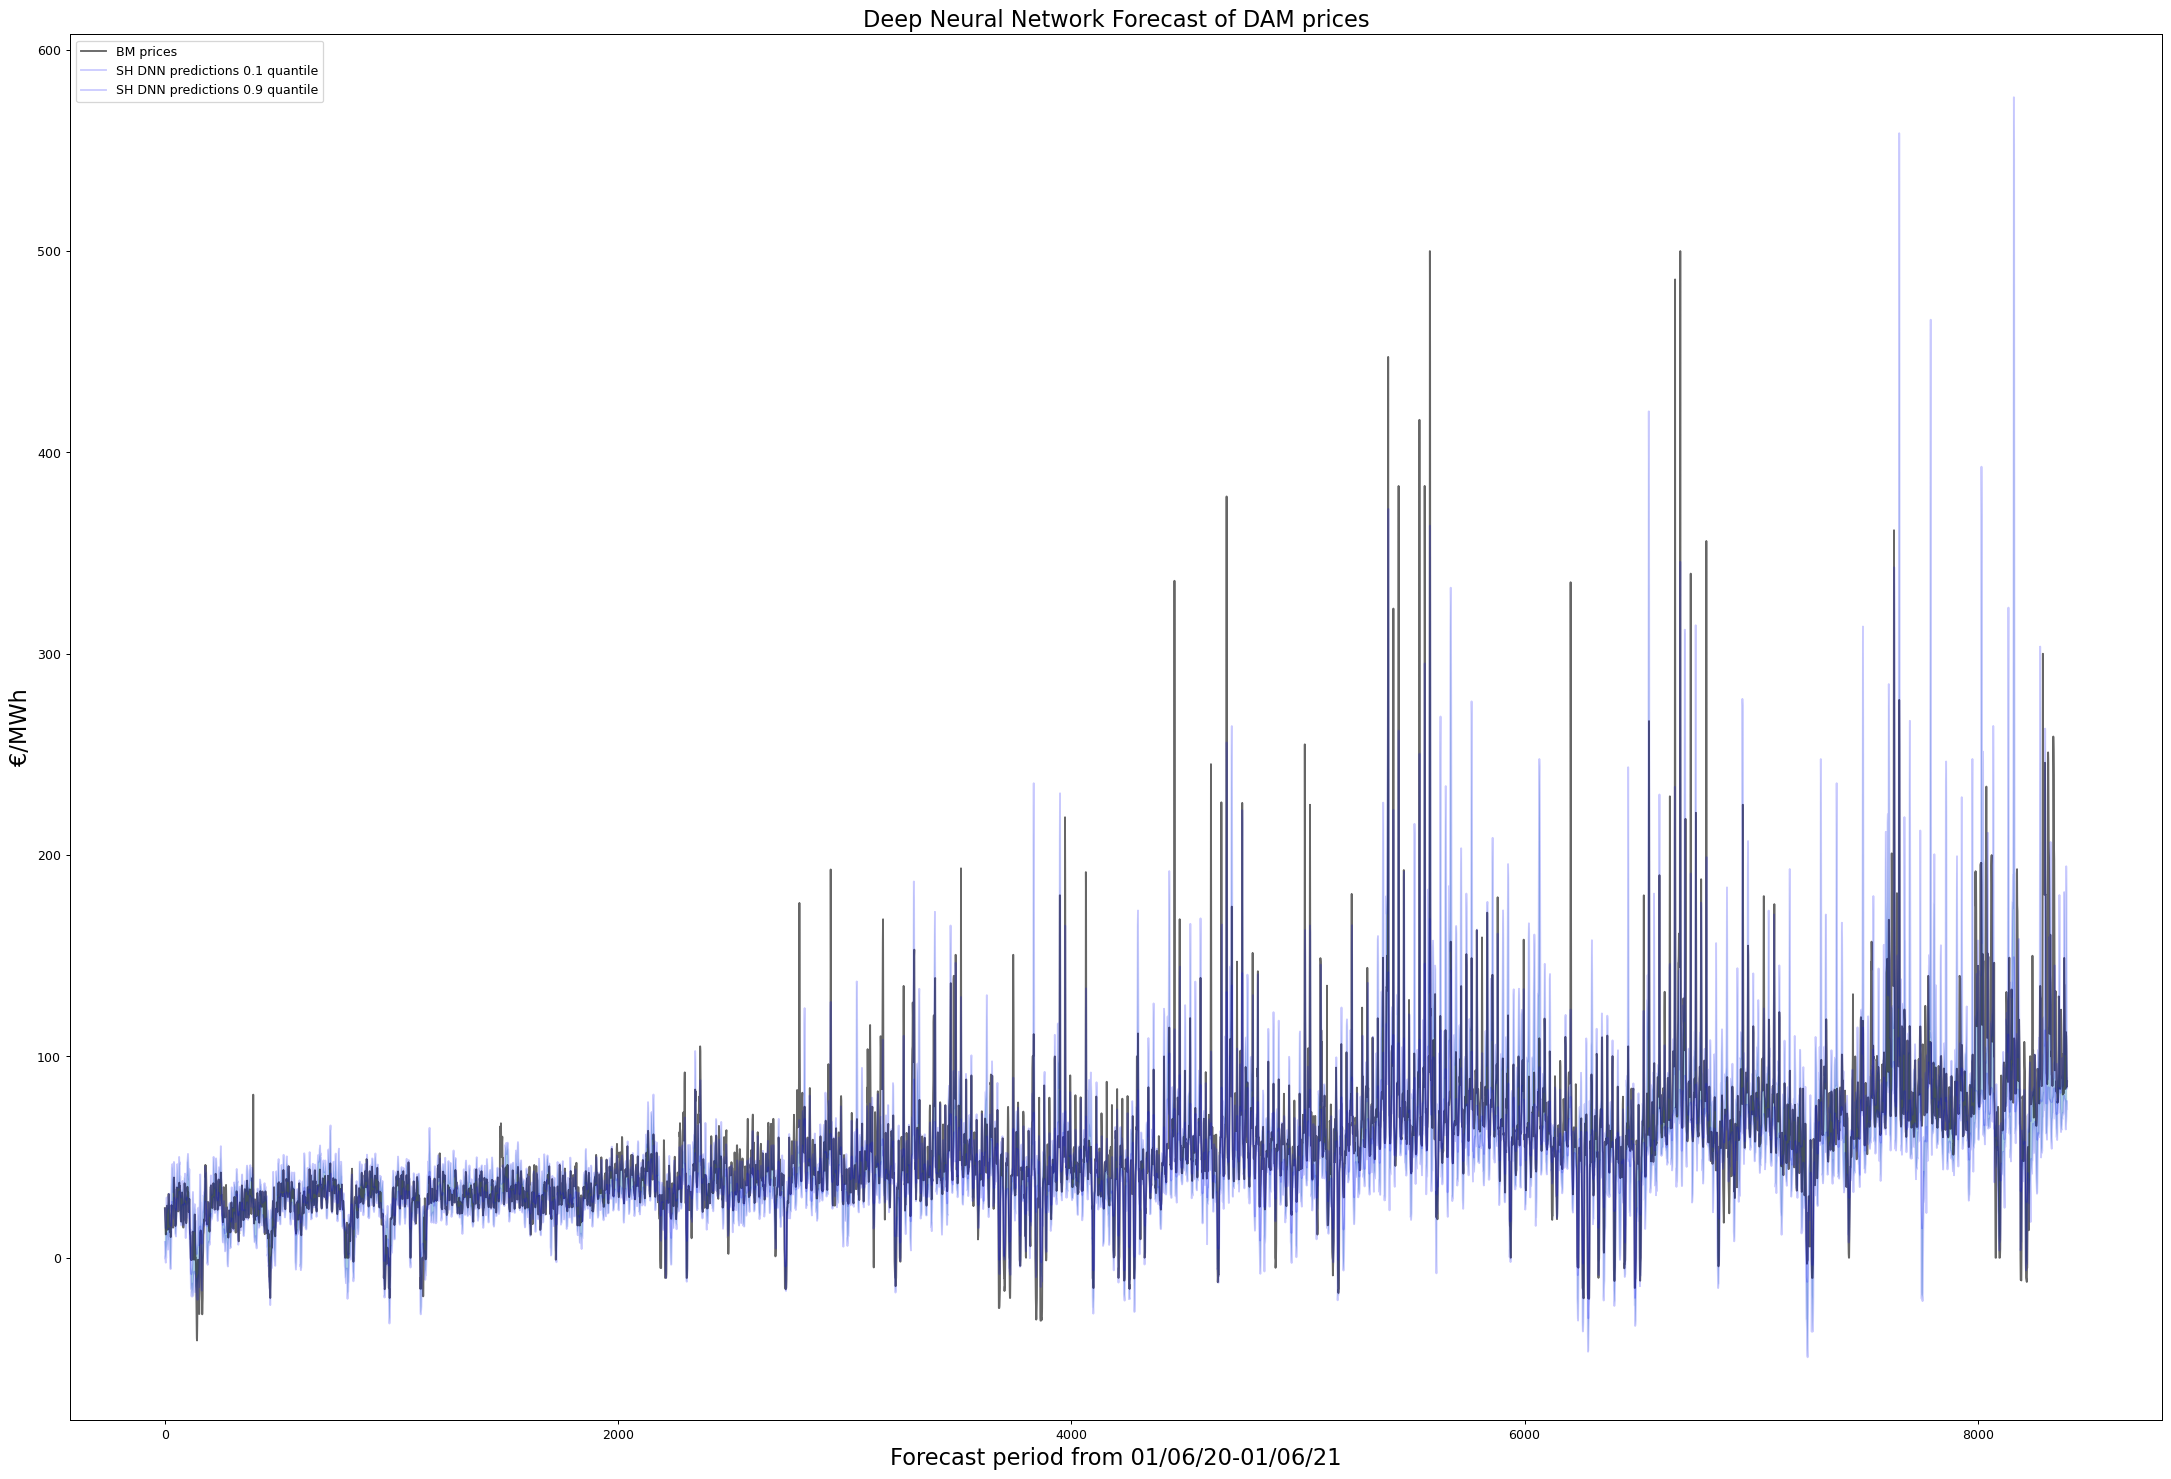

In [40]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/SH_A_Q_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 25.61
RMSE: 21.97
RMSE: 20.70
RMSE: 20.23
RMSE: 25.15
RMSE: 22.73

Performance Metrics for Quantile MAE:
MAE: 15.17
MAE: 11.99
MAE: 11.08
MAE: 11.08
MAE: 14.09
MAE: 12.68

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.30
Pinball Score: 4.50
Pinball Score: 5.54
Pinball Score: 5.41
Pinball Score: 3.70
Pinball Score: 4.29

Performance Metrics for Quantile sMAPE:
sMAPE: 36.56
sMAPE: 27.91
sMAPE: 25.27
sMAPE: 24.75
sMAPE: 28.20
sMAPE: 28.54

Performance Metrics for Quantile Winkler Score:
Winkler Score: 23.68
Winkler Score: 40.51
Winkler Score: 44.31
Winkler Score: 78.08
Winkler Score: 63.55
Winkler Score: 36.17

Performance Metrics for Quantile Mean Width:
Mean Width: 21.66
Mean Width: 8.89
Mean Width: 0.00
Mean Width: 8.89
Mean Width: 21.66
Mean Width: 15.27

Performance Metrics for Quantile coverage:
coverage: 0.58
coverage: 0.26
coverage: 0.61
coverage: 0.02
coverage: 0.00
coverage: 0.48

Total hours that reject the null hy

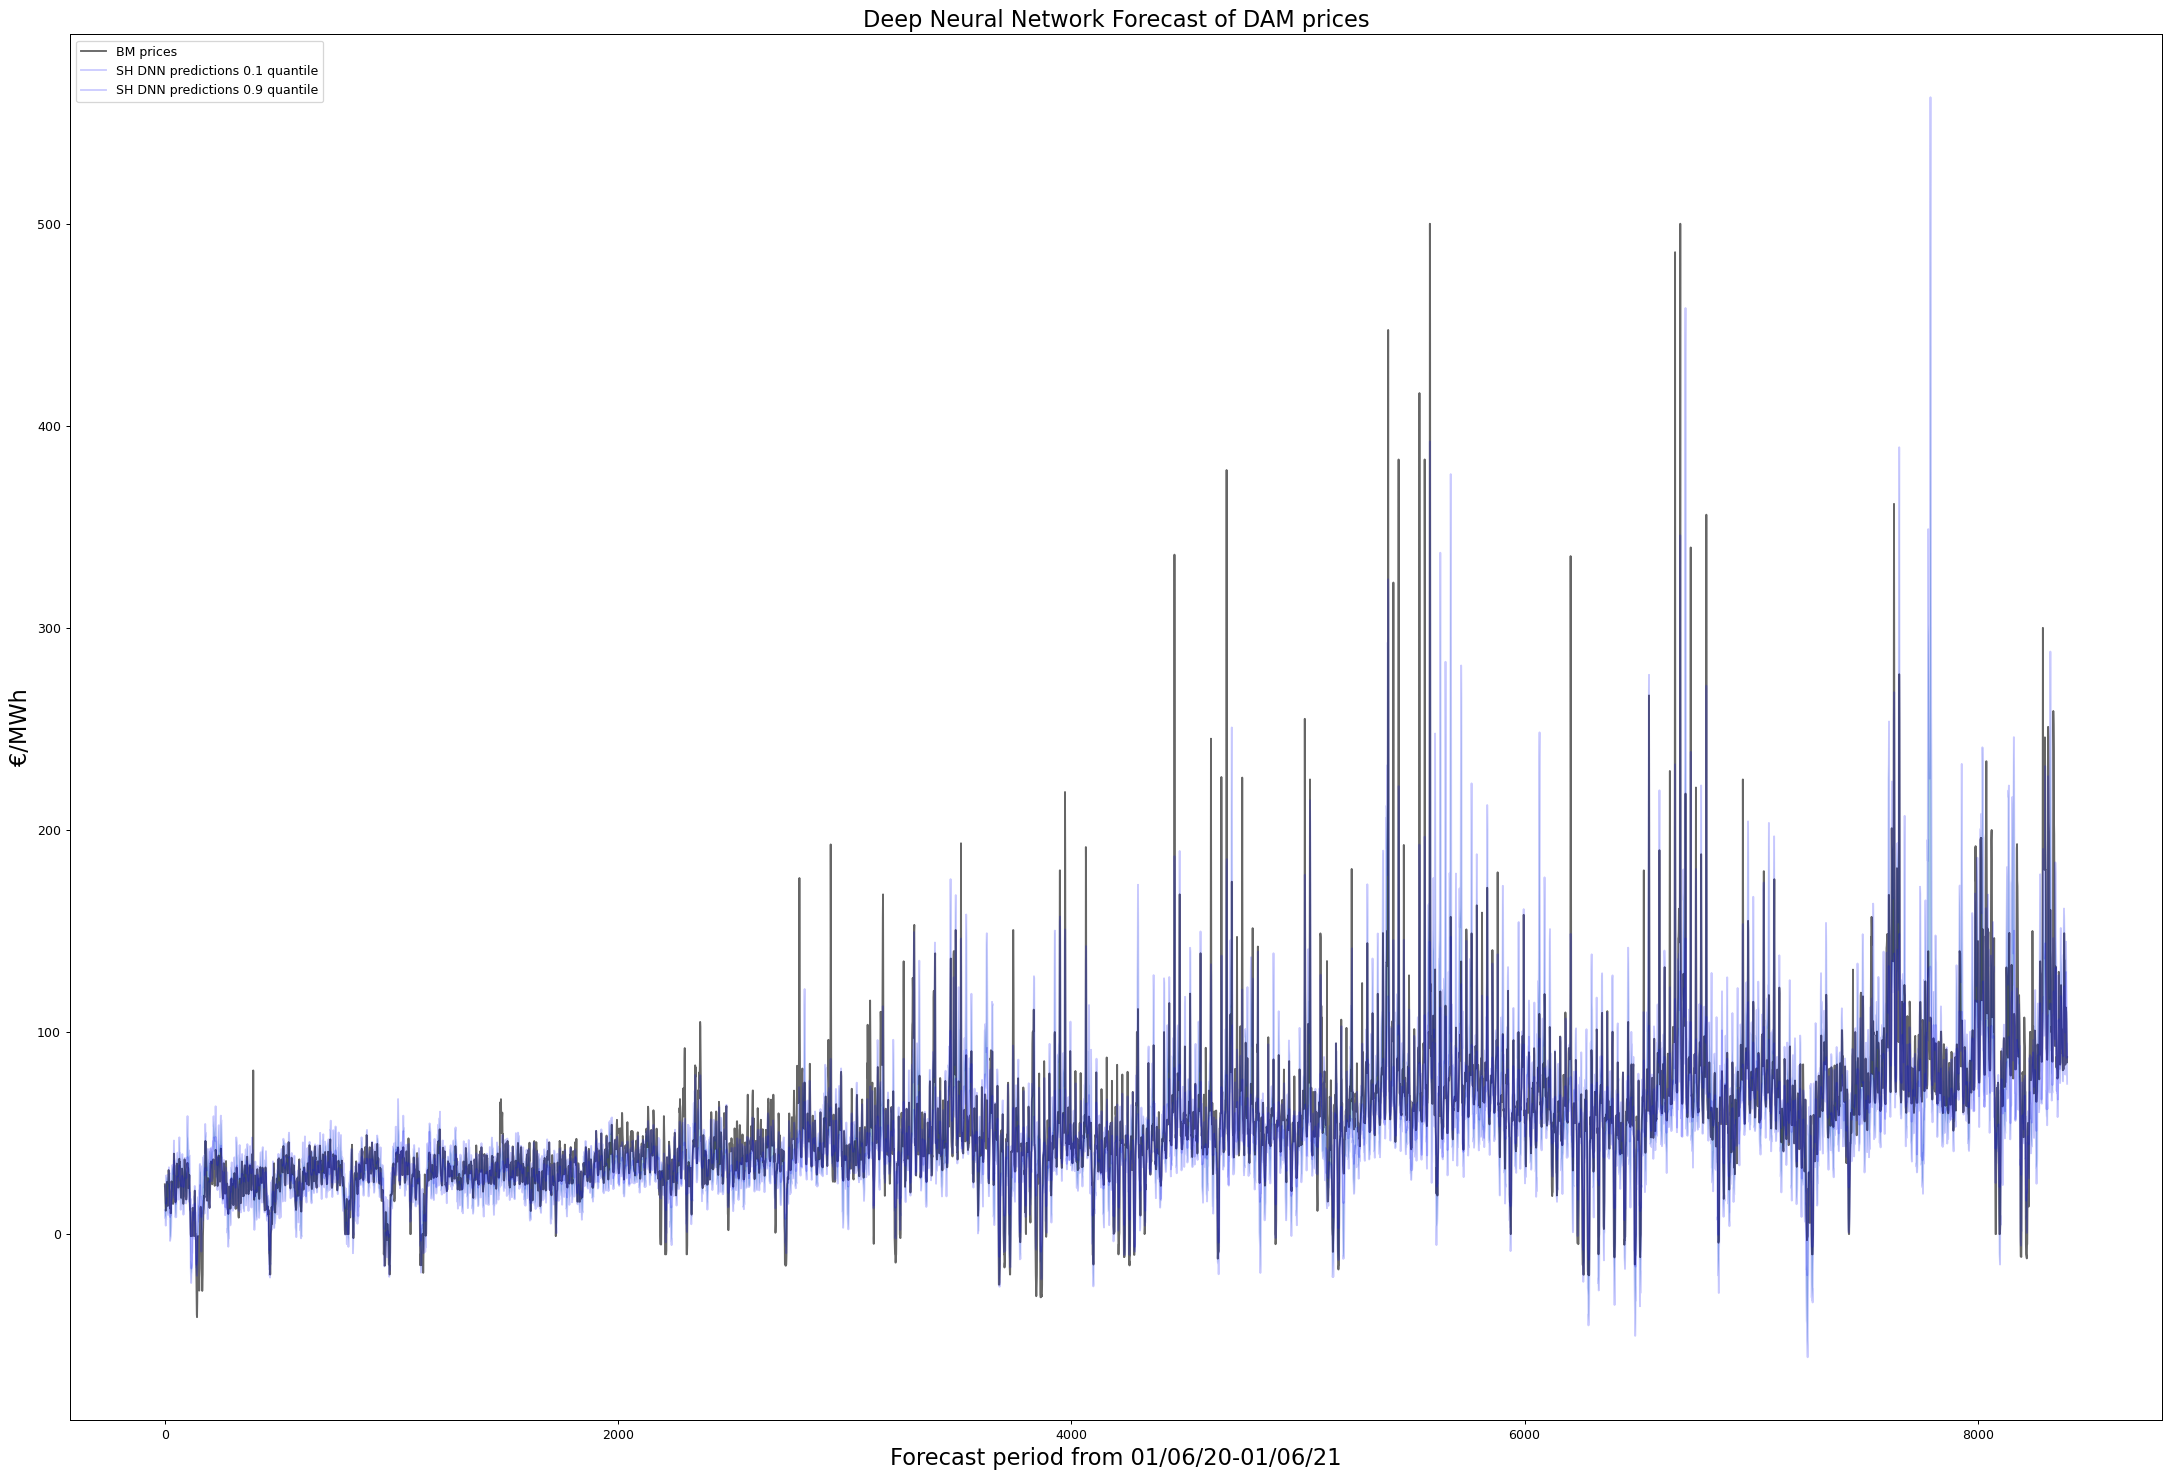

In [41]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Subset_QRA/SH_A_Q_DAM_QRA_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[121:,:].reset_index(drop=True)


column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 29.08
RMSE: 25.90
RMSE: 25.91
RMSE: 20.70
RMSE: 26.19
RMSE: 25.56

Performance Metrics for Quantile MAE:
MAE: 16.82
MAE: 12.95
MAE: 13.25
MAE: 11.05
MAE: 16.24
MAE: 14.06

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.12
Pinball Score: 4.46
Pinball Score: 6.62
Pinball Score: 5.68
Pinball Score: 4.07
Pinball Score: 4.59

Performance Metrics for Quantile sMAPE:
sMAPE: 39.48
sMAPE: 28.24
sMAPE: 28.50
sMAPE: 25.18
sMAPE: 31.68
sMAPE: 30.62

Performance Metrics for Quantile Winkler Score:
Winkler Score: 28.48
Winkler Score: 41.71
Winkler Score: 52.99
Winkler Score: 83.40
Winkler Score: 73.67
Winkler Score: 41.06

Performance Metrics for Quantile Mean Width:
Mean Width: 26.01
Mean Width: 10.78
Mean Width: 0.00
Mean Width: 10.78
Mean Width: 26.01
Mean Width: 18.40

Performance Metrics for Quantile coverage:
coverage: 0.67
coverage: 0.30
coverage: 0.66
coverage: 0.02
coverage: 0.00
coverage: 0.54

Total hours that reject the null 

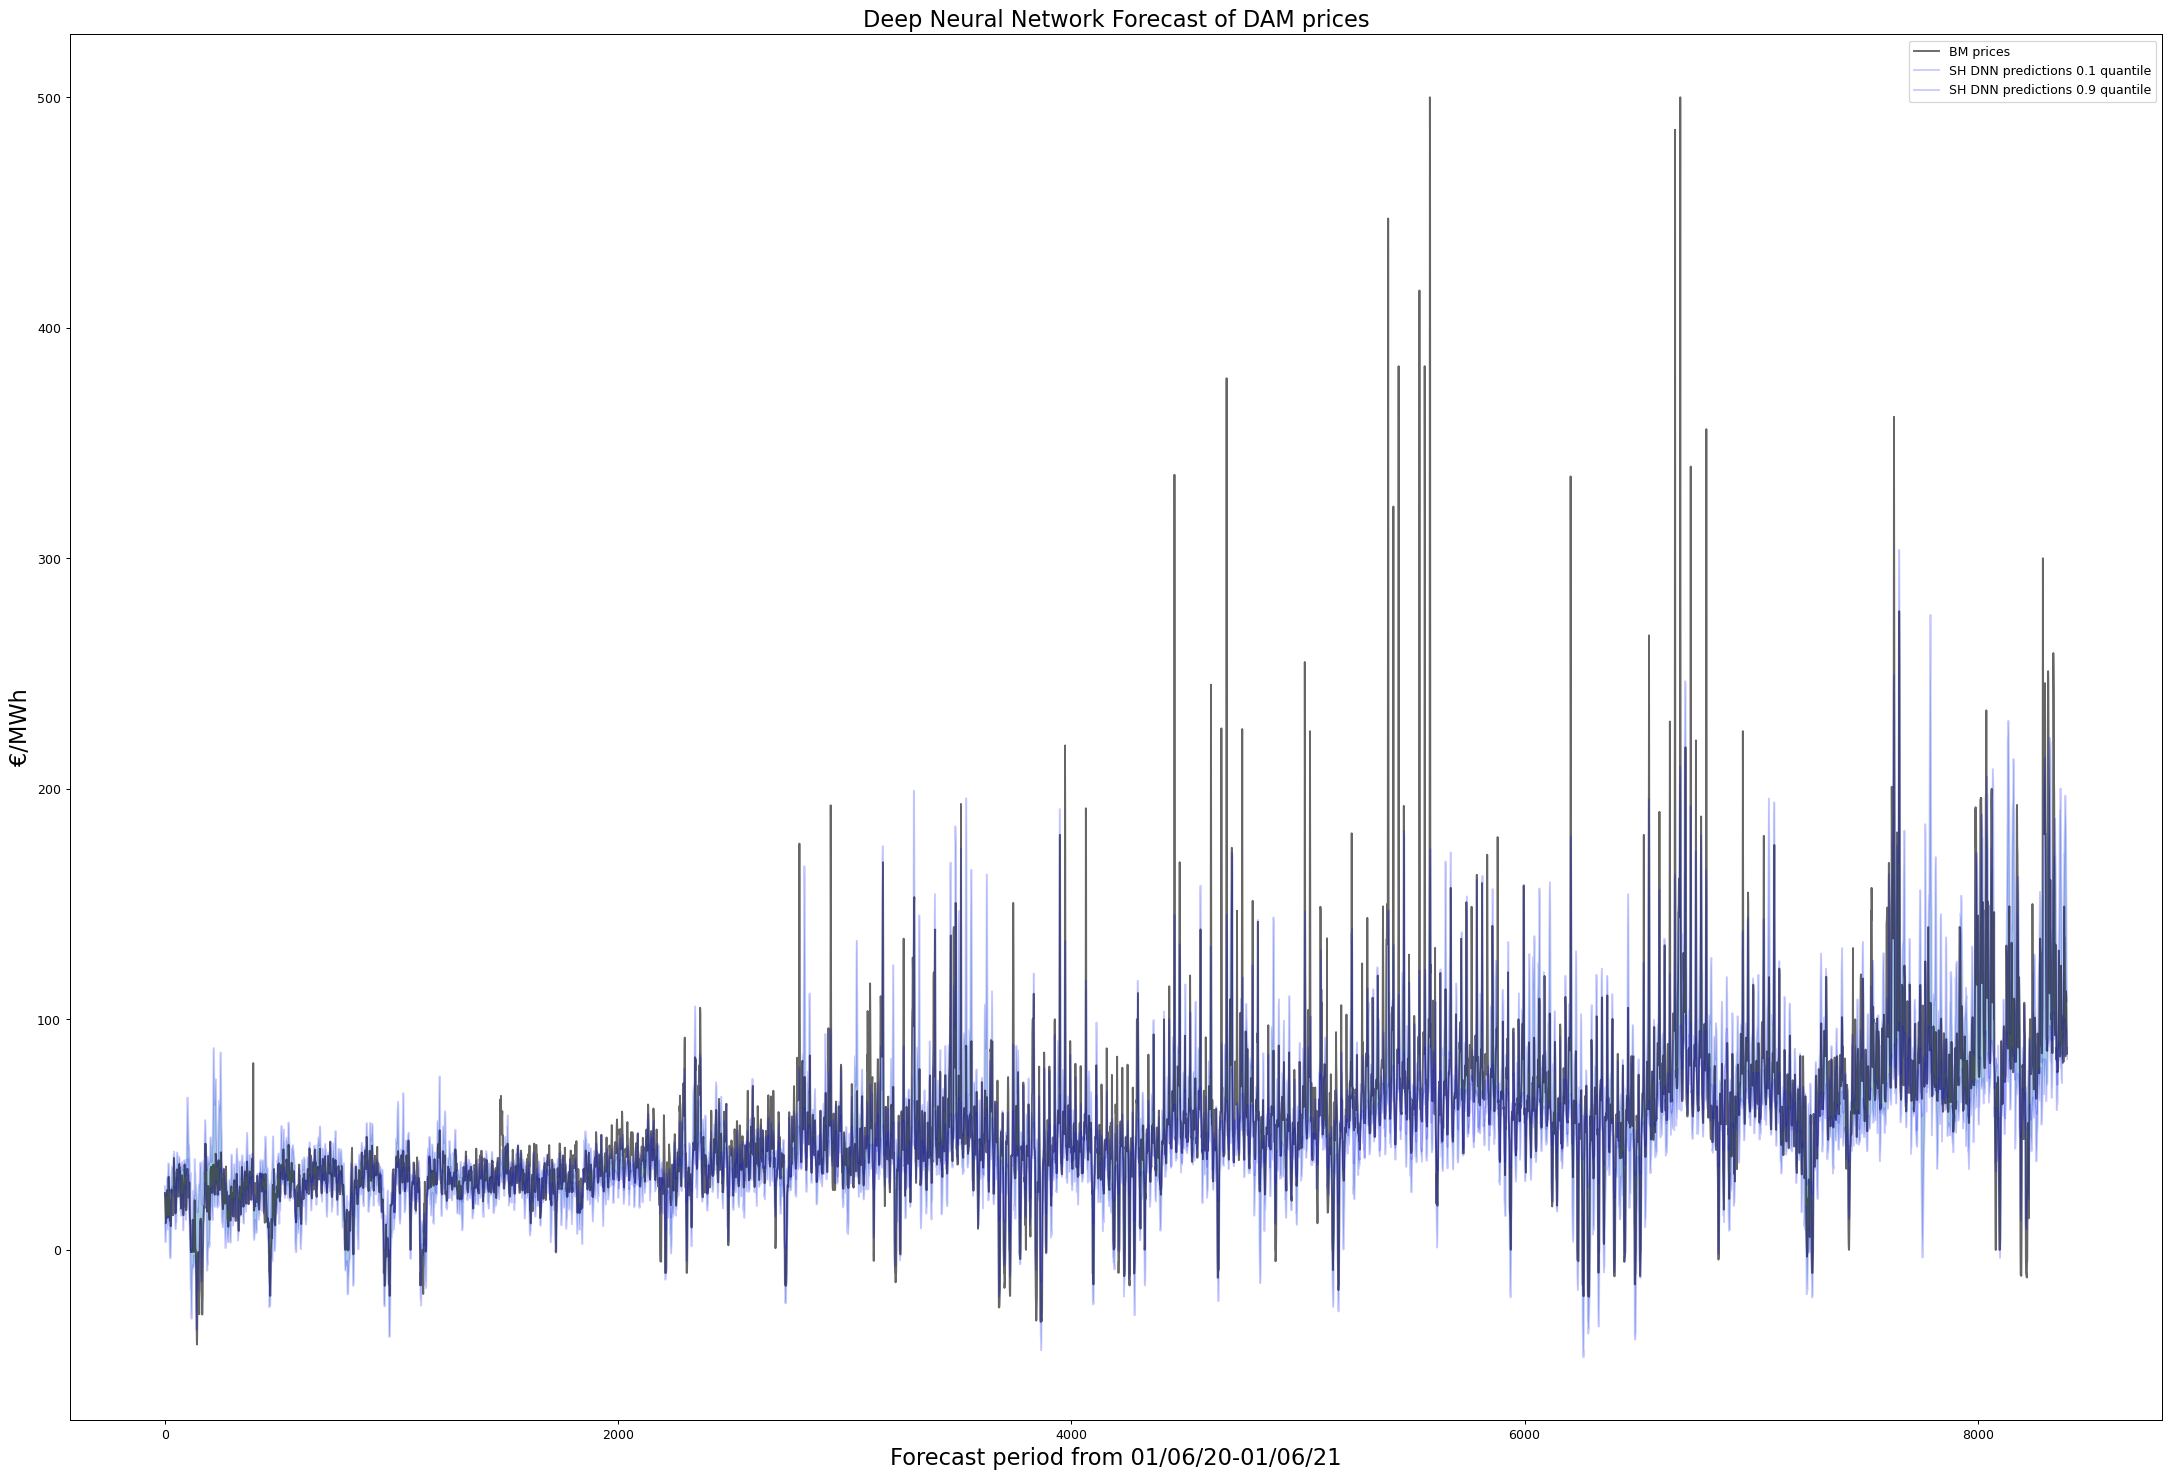

In [42]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/SH_B_Q_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.99  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 27.17
RMSE: 21.84
RMSE: 20.87
RMSE: 21.77
RMSE: 27.14
RMSE: 23.76

Performance Metrics for Quantile MAE:
MAE: 15.83
MAE: 12.23
MAE: 10.41
MAE: 11.37
MAE: 15.26
MAE: 13.02

Performance Metrics for Quantile Pinball Score:
Pinball Score: 2.06
Pinball Score: 4.46
Pinball Score: 5.20
Pinball Score: 5.31
Pinball Score: 3.37
Pinball Score: 4.08

Performance Metrics for Quantile sMAPE:
sMAPE: 37.26
sMAPE: 28.15
sMAPE: 23.95
sMAPE: 24.38
sMAPE: 29.40
sMAPE: 28.63

Performance Metrics for Quantile Winkler Score:
Winkler Score: 25.70
Winkler Score: 38.57
Winkler Score: 41.63
Winkler Score: 84.55
Winkler Score: 70.48
Winkler Score: 35.30

Performance Metrics for Quantile Mean Width:
Mean Width: 25.37
Mean Width: 11.14
Mean Width: 0.00
Mean Width: 11.14
Mean Width: 25.37
Mean Width: 18.25

Performance Metrics for Quantile coverage:
coverage: 0.66
coverage: 0.31
coverage: 0.62
coverage: 0.01
coverage: 0.00
coverage: 0.53

Total hours that reject the null 

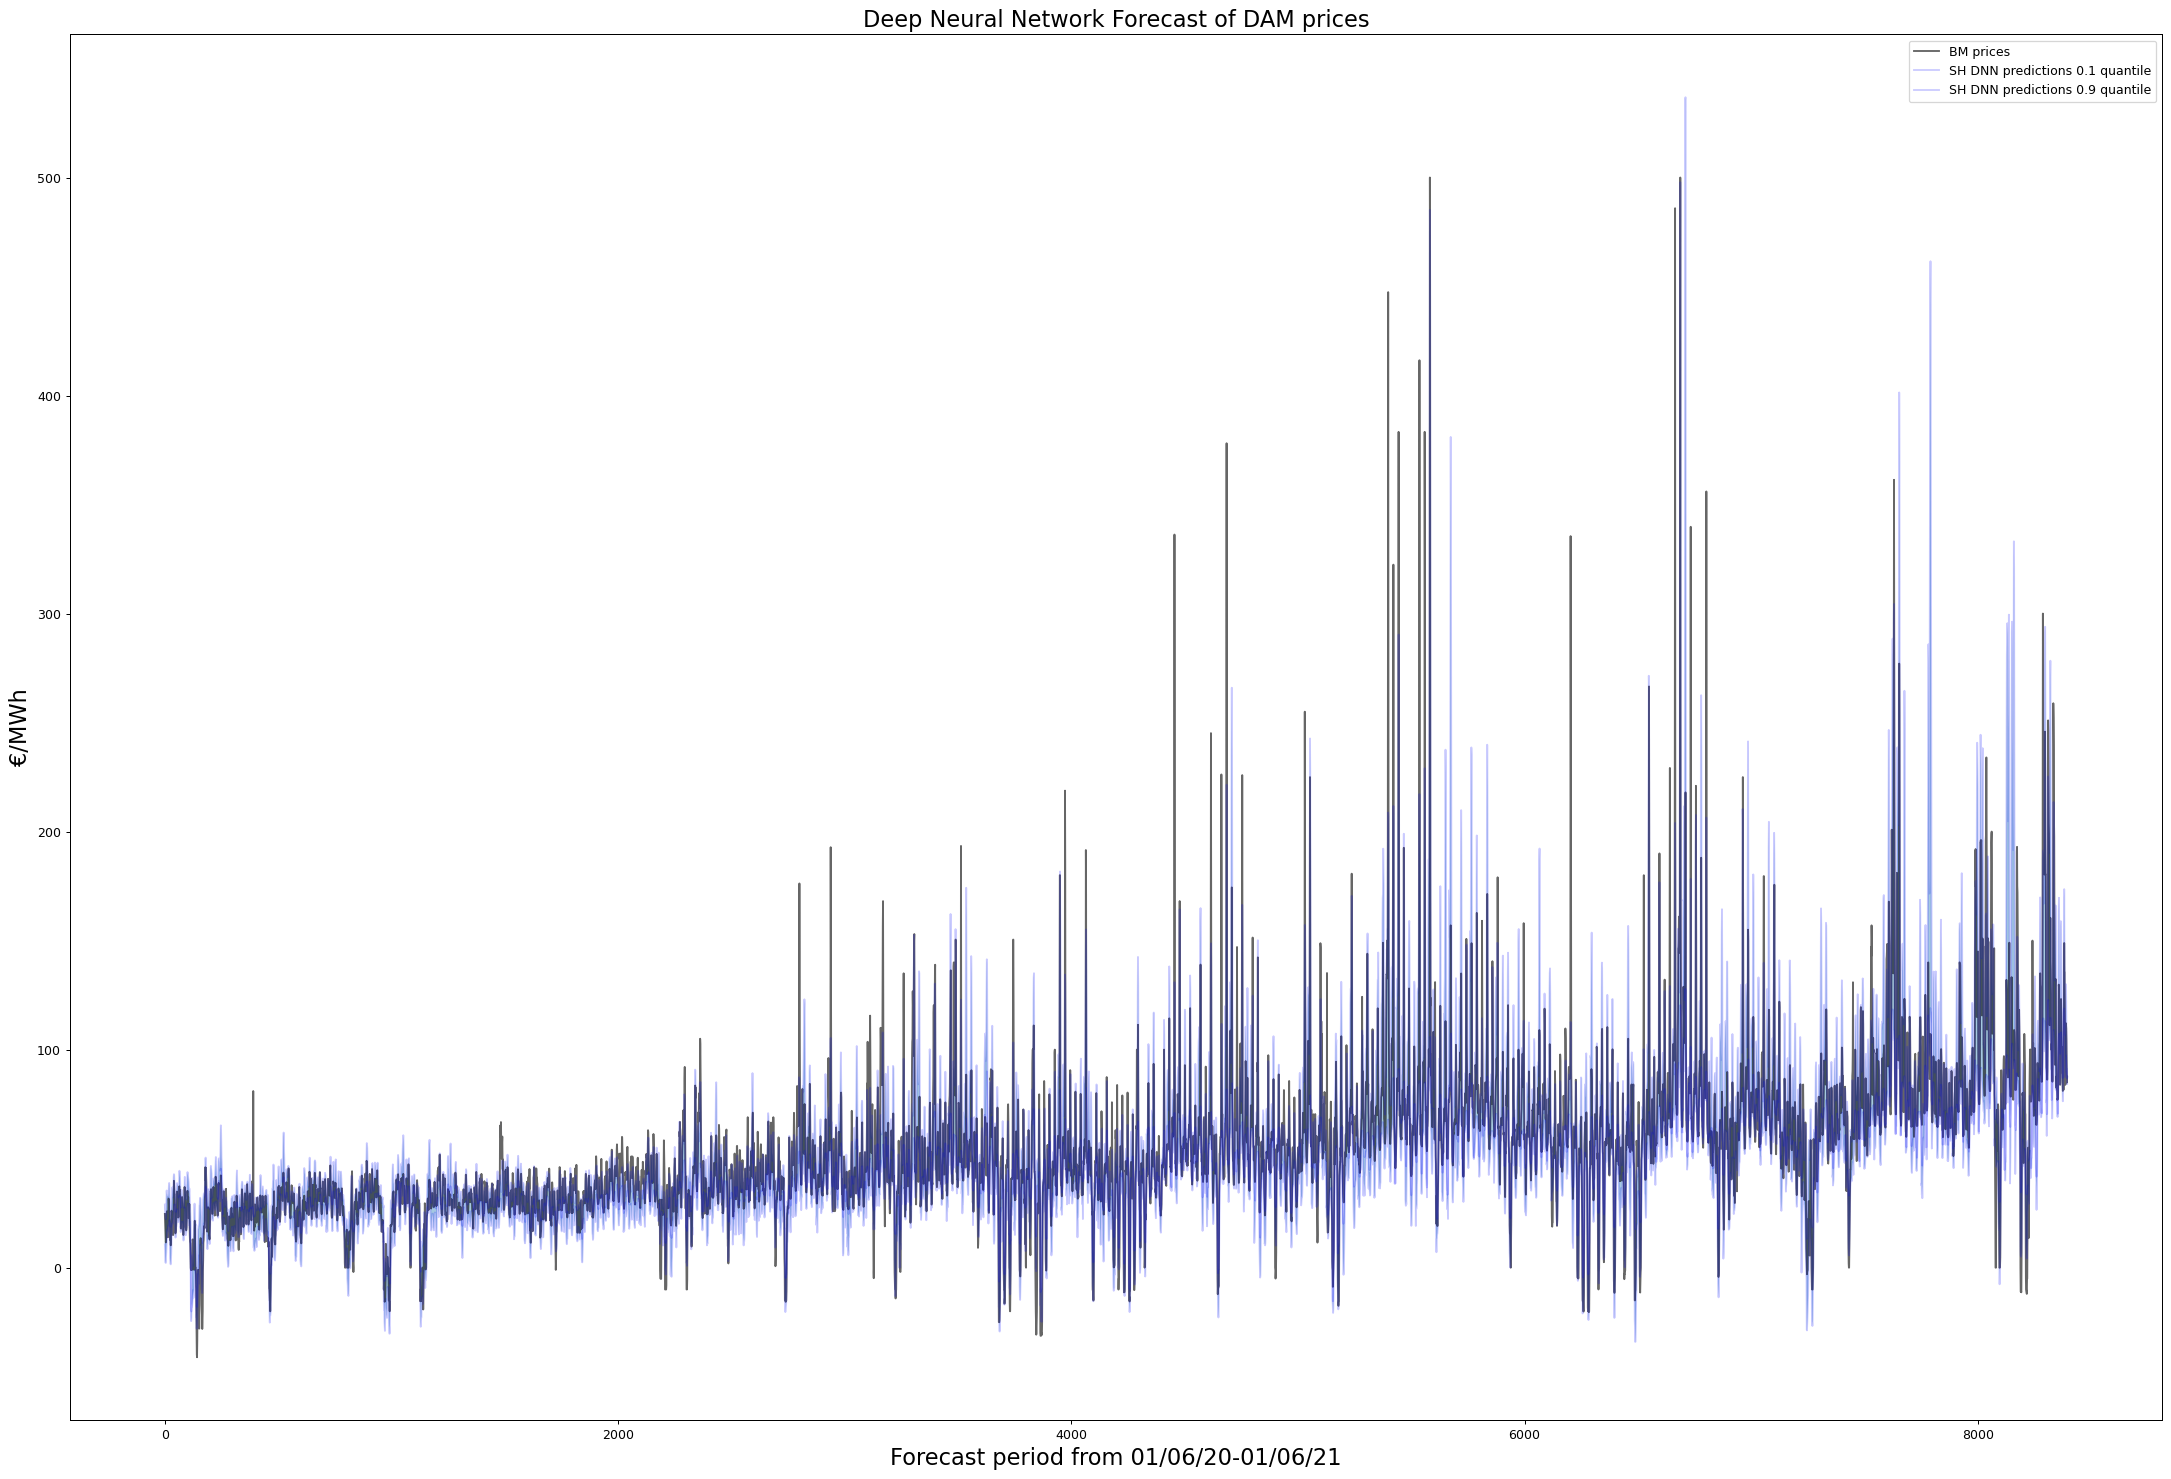

In [43]:
date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Subset_QRA/SH_B_Q_DAM_QRA_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[121:,:].reset_index(drop=True)


column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.99  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

In [ ]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)
def pinball(y_true, quantile_forecast, alpha):
    pinball_loss = np.maximum((y_true - quantile_forecast) * alpha, (quantile_forecast - y_true) * (1 - alpha))
    return np.mean(pinball_loss)
def kupiec_test(y_true, quantile_forecast, alpha=0.05):
    binary_forecast = (quantile_forecast <= alpha).astype(int)
    successes = np.sum((y_true == 1) & (binary_forecast == 1))
    failures = np.sum((y_true == 0) & (binary_forecast == 1))
    log_likelihood_model = np.sum(np.log(quantile_forecast[y_true == 1]))
    log_likelihood_no_model = np.sum(np.log(1 - quantile_forecast[y_true == 0]))
    test_statistic = -2 * (log_likelihood_model + log_likelihood_no_model)
    p_value = 1 - chi2.cdf(test_statistic, df=2)
    return test_statistic, p_value

def winkler_score(y_true, lower_bound, upper_bound, alpha):
    if alpha == 0.3 or alpha == 0.7:
        alpha = 0.4
    elif alpha == 0.1 or alpha == 0.9:
        alpha = 0.8   
    y_true = np.array(y_true)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)
    B_t_h = upper_bound - lower_bound
    within_interval = (y_true >= lower_bound) & (y_true <= upper_bound)    
    score = np.zeros_like(y_true, dtype=float)    
    if alpha == 0.5:
        score += np.where(within_interval, 0.5 * B_t_h, 0)  # Condition 1 (special case for alpha=0.5)
    else:
        score += np.where(within_interval, B_t_h, 0)  # Condition 1
    score += np.where(y_true < lower_bound, (2 / alpha) * (lower_bound - y_true), 0)  # Condition 2
    score += np.where(y_true > upper_bound, (2 / alpha) * (y_true - upper_bound), 0)  # Condition 3
    winkler_score = np.mean(score)
    return winkler_score
def calculate_picp(y_true, lower_bound, upper_bound):
    within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)
    picp = np.mean(within_interval)
    return picp
def calculate_uc_cc(y_true, lower_bound, upper_bound):
    within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)
    uc = np.mean(within_interval)    
    independence = np.mean(np.logical_and(lower_bound <= y_true.shift(1), y_true.shift(1) <= upper_bound.shift(1)))
    cc = uc + independence    
    return uc, cc
def assess_prediction_intervals(y_true, lower_bound, upper_bound, alpha=0.05):
    within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)
    empirical_coverage = np.mean(within_interval)
    sharpness = np.mean(upper_bound - lower_bound)
    return empirical_coverage, sharpness
def calculate_additional_metrics(y_true, lower_bound, upper_bound, alpha):
    reliability, sharpness = assess_prediction_intervals(y_true, lower_bound, upper_bound)
    kupiec_statistic, kupiec_p_value = kupiec_test(y_true, upper_bound, alpha=alpha)
    winkler = winkler_score(y_true, lower_bound, upper_bound, alpha)
    width = np.abs(upper_bound - lower_bound).mean().values[0]
    picp = calculate_picp(y_true, lower_bound, upper_bound)
    uc, cc = calculate_uc_cc(y_true, lower_bound, upper_bound)
    return reliability, sharpness, kupiec_statistic, kupiec_p_value, winkler, width, picp, uc, cc

In [ ]:
import numpy as np
import scipy.stats

def custom_GW(p_real, p_pred_1, p_pred_2, norm=1, version='univariate'):
    if p_real.shape != p_pred_1.shape or p_real.shape != p_pred_2.shape:
        raise ValueError('The three time series must have the same shape')

    if len(p_real.shape) == 1 or (len(p_real.shape) == 2 and p_real.shape[1] == 1):
        raise ValueError('The time series must have shape (n_days, n_prices_day')

    loss1 = p_real - p_pred_1
    loss2 = p_real - p_pred_2
    tau = 1
    if norm == 1:
        d = np.abs(loss1) - np.abs(loss2)
    else:
        d = loss1**2 - loss2**2
    TT = np.max(d.shape)

    if version == 'univariate':
        GWstat = np.inf * np.ones((np.min(d.shape),))
        for h in range(p_real.shape[1]):
            instruments = np.stack([np.ones_like(d[:-tau, h]), d[:-tau, h]])
            dh = d[tau:, h]
            T = TT - tau

            instruments = np.array(instruments, ndmin=2)

            reg = np.ones_like(instruments) * -999
            for jj in range(instruments.shape[0]):
                reg[jj, :] = instruments[jj, :] * dh

            if tau == 1:
                betas = np.linalg.lstsq(reg.T, np.ones(T), rcond=None)[0]
                err = np.ones((T, 1)) - np.dot(reg.T, betas)
                r2 = 1 - np.mean(err**2)
                GWstat[h] = T * r2
            else:
                raise NotImplementedError('Only one-step forecasts are implemented')

    elif version == 'multivariate':
        d = d.mean(axis=1)
        instruments = np.stack([np.ones_like(d[:-tau]), d[:-tau]])
        d = d[tau:]
        T = TT - tau

        instruments = np.array(instruments, ndmin=2)

        reg = np.ones_like(instruments) * -999
        for jj in range(instruments.shape[0]):
            reg[jj, :] = instruments[jj, :] * d

        if tau == 1:
            betas = np.linalg.lstsq(reg.T, np.ones(T), rcond=None)[0]
            err = np.ones((T, 1)) - np.dot(reg.T, betas)
            r2 = 1 - np.mean(err**2)
            GWstat = T * r2
        else:
            raise NotImplementedError('Only one-step forecasts are implemented')

    GWstat *= np.sign(np.mean(d, axis=0))

    q = reg.shape[0]
    pval = 1 - scipy.stats.chi2.cdf(GWstat, q)
    return pval


In [ ]:
# from epftoolbox.evaluation import GW
import pandas as pd
import scipy

date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/lgbm_Q_DAM_1-12.csv")
dat1=pd.DataFrame(dat1)
dat1=dat1.iloc[152:,:].reset_index(drop=True)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10_A=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30_A=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50_A=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70_A=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90_A=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test_A=dat1[column_names].dropna().stack().reset_index()


date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat2 = pd.read_csv("/home/ciaran/DAM_QRA/Model_preds/rf_SPCI_DAM_1-12.csv")
dat2=pd.DataFrame(dat2)


column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 23)]
Q_10_B=dat2[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 23)]
Q_30_B=dat2[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 23)]
Q_50_B=dat2[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 23)]
Q_70_B=dat2[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 23)]
Q_90_B=dat2[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 23)]
YY_test_B=dat2[column_names].dropna().stack().reset_index()

real_price_A = YY_test_A.iloc[:, 2:].values
real_price_B = YY_test_B.iloc[:, 2:].values

# Assuming the third column (0-indexed) contains the forecast in Q_10_A and Q_10_B
forecast_A = Q_50_B.iloc[:, 2:].values
forecast_B = Q_50_A.iloc[:, 2:].values

# Assuming 23 prices per day, adjust the reshape dimensions accordingly
gw_results_10 = custom_GW(p_real=real_price_A.reshape(-1, 23),
                          p_pred_1=forecast_A.reshape(-1, 23),
                          p_pred_2=forecast_B.reshape(-1, 23),
                          norm=1, version='univariate')

print("GW Results (univariate):", gw_results_10)


In [ ]:
quantiles = [10, 30, 50, 70, 90]

results = []

for quantile in quantiles:
    quantile_column_name = 'Q_{}'.format(quantile)
    quantile_forecast = globals()[quantile_column_name]

    for hour in range(24):  # Adjust the range based on your actual data
        y_true_column = 'YY_test'
        y_true = globals()[y_true_column].iloc[:, 0]

        hour_column_name = 'Q_{}'.format(quantile)
        hour_quantile_forecast = quantile_forecast.iloc[:, 0]

        test_statistic, p_value = kupiec_test(y_true, hour_quantile_forecast, alpha=0.05)

        results.append({
            'Hour': hour,
            'Quantile': quantile,
            'Test Statistic': test_statistic,
            'P-Value': p_value
        })

results_df = pd.DataFrame(results)

print(results_df[48:72])